In [1]:
import optuna
import os

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torch.utils.data import Dataset,DataLoader,random_split
from torch.utils.tensorboard import SummaryWriter
from torchvision import models, transforms
from torch_lr_finder import LRFinder

import h5py
import copy
from datetime import datetime
import matplotlib.pyplot as plt

from Library.datasets import DatasetH5TwoRandom, DatasetH5ForTest, compute_std_mean
from Library.transforms import RandomFlip,RandomOffset,RandomRotateGrayscale
from Library.scheduler import OneCycleLR,LogLR
from Library.cresnet import initialize_cresnet
from Library.dml import RefBasedDeepMetric
from Library.models.FeatureExtractor import FeatureExtractor, Block, CustomNet
from Library.trainers import RefBasedDeepMetricTrainer
from tqdm.notebook import tqdm

In [2]:
from Library.util import (
    jupyter_wide_screen,
    strings_contain_words, 
    strings_contain_patterns, 
    add_unique_entry
)

jupyter_wide_screen()

In [3]:
def init_dataset(path,seq_idx_list,mean_val,std_val):

    ds_h5 = []
    refs_list = []

    img_transforms = [RandomRotateGrayscale(rot_range=[-0.1, 0.1], fill=150),
                      RandomFlip(lr_prob=0.5, ud_prob=0.5),
                      transforms.ToTensor(),
                      transforms.Normalize((mean_val,),(std_val,))]
    
    composed_img_transforms = transforms.Compose(img_transforms)
    
    # to obtain the Seq data
    for seq_idx in seq_idx_list:
        h5_fpath = path.format(seq_idx)
        h5_f = DatasetH5TwoRandom(h5_fpath,transform = composed_img_transforms)
        
        # obtain the references, the first 10 images in every Seq.
        refs = h5_f.getRef()
        refs_list.append(refs)
        
        ds_h5.append(h5_f)

    return refs_list, ds_h5

def init_dataloaders(datasets,ds_ratio):
    dataloaders = []
    
    for ds in datasets:
        splitted_ds_num_data = [round(len(ds) * ds_ratio[i]) for i in range(len(ds_ratio))]
        splitted_ds_num_data[0] += len(ds) - int(np.sum(splitted_ds_num_data))

        splitted_ds = []

        for tmp_ds, batch_size, shuffle in zip(random_split(ds, splitted_ds_num_data), batch_sizes, shuffle_flags):

            splitted_ds.append(
                DataLoader(
                    tmp_ds,
                    batch_size=batch_size,
                    shuffle=shuffle,
                    drop_last=True,
                )
            )

        dataloaders.append(splitted_ds)
    return dataloaders


# Load Model

In [4]:
model_path = 'optuna_models/RefFreeDeepMetric_Model_v6_old_3stride_t2'

In [5]:
with open(os.path.join(model_path, 'config.json')) as f:
    cresnet_config = json.load(f)
    
weight_fpath = os.path.join(model_path, 'model.weight')

device = torch.device("cuda:0")

In [6]:
cresnet_config

{'loss_non_linearity_name': 'sigmoid',
 'criterion_name': 'bce',
 'cresnet_config': {'InputShape': [1, 720, 24],
  'BlockName': 'LeakyBasicBlock',
  'NumBlocks': [3, 3, 3, 3, 3, 3, 3],
  'NumChannels': [24, 24, 48, 48, 96, 96, 192],
  'Strides': [[2, 2], [2, 2], [2, 1], [2, 2], [2, 2], [2, 1], [2, 1]],
  'NumNeurons': [32],
  'EnableGlobalAveragePooling': True,
  'PrintIntermediateShape': False,
  'InitializeResidual': True}}

In [9]:
cresnet_config = {
        'InputShape' : [1, 720, 24],
        'BlockName' : 'LeakyBasicBlock',
        'NumBlocks' : [3, 3, 3, 3, 3, 3, 3],
        'NumChannels' : [24, 24, 48, 48, 96, 96, 192],
        'Strides' :[[2, 2], [2, 2], [2, 1], [2, 2], [2, 2], [2, 1], [2, 1]],
        'NumNeurons' :[32],
        'EnableGlobalAveragePooling' : True,
        'PrintIntermediateShape' : True,
        'InitializeResidual': True,
    }

In [10]:
feature_extractor = initialize_cresnet(cresnet_config, device)
model = RefBasedDeepMetric(
    feature_extractor, 
    loss_non_linearity_name='sigmoid',
    criterion_name='bce',)

[torch.Size([1, 24, 360, 12]), torch.Size([1, 24, 180, 6]), torch.Size([1, 48, 90, 6]), torch.Size([1, 48, 45, 3]), torch.Size([1, 96, 23, 2]), torch.Size([1, 96, 12, 2]), torch.Size([1, 192, 6, 2]), torch.Size([1, 192, 1, 1])]


In [11]:
model.to(device)

RefBasedDeepMetric(
  (feature_extractor): CResNet(
    (Block0): Sequential(
      (0): LeakyBasicBlock(
        (conv1): Conv2d(1, 24, kernel_size=(3, 3), stride=[2, 2], padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): LeakyReLU(negative_slope=0.01, inplace=True)
        (conv2): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (downsample): Sequential(
          (0): Conv2d(1, 24, kernel_size=(1, 1), stride=[2, 2], bias=False)
          (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (1): LeakyBasicBlock(
        (conv1): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

# Initial 1 stripe dataset

In [12]:
#One Stripe Data -- Type 2
data_path_type2 = "../MA/NewData/21503_1000200411_653340003"
fnames_type2 = "trueroi_filtered_phase2_1_{}.h5" # 2,3,4
combined_path_type2 = os.path.join(data_path_type2, fnames_type2)
seq_idx_list_type2 = [2,3,4]

In [13]:
inputs_shape = [1,720,24]
batch_sizes = [32, 32, 32]
shuffle_flags = [True, False, False]
ds_ratio = [0.6, 0.2, 0.2]

In [15]:
mean_val = 0
std_val = 255
refs_list, ds_h5 = init_dataset(combined_path_type2, seq_idx_list_type2, mean_val, std_val)

In [16]:
len(ds_h5)

3

In [17]:
dataloaders = init_dataloaders(ds_h5, ds_ratio)
train_dls = [dls[0] for dls in dataloaders]
valid_dls = [dls[1] for dls in dataloaders]
test_dls = [dls[2] for dls in dataloaders]

# LR test

In [18]:
from torch.optim.lr_scheduler import _LRScheduler
from torch_lr_finder import LRFinder ,TrainDataLoaderIter, ValDataLoaderIter

In [19]:
class CustomTrainIter(TrainDataLoaderIter):
    def inputs_labels_from_batch(self, batch_data):
        img1, img2, labels = batch_data
        return img1, img2, labels
    
    def __next__(self):
        try:
            batch = next(self._iterator)
            img1, img2, labels = self.inputs_labels_from_batch(batch)
        except StopIteration:
            if not self.auto_reset:
                raise
            self._iterator = iter(self.data_loader)
            batch = next(self._iterator)
            img1, img2, labels = self.inputs_labels_from_batch(batch)

        return img1, img2, labels

In [20]:
class CustomValIter(ValDataLoaderIter):
    def inputs_labels_from_batch(self, batch_data):
        img1, img2, labels = batch_data
        return img1, img2, labels

In [21]:
class LinearLR(_LRScheduler):
    """Linearly increases the learning rate between two boundaries over a number of
    iterations.

    Arguments:
        optimizer (torch.optim.Optimizer): wrapped optimizer.
        end_lr (float): the final learning rate.
        num_iter (int): the number of iterations over which the test occurs.
        last_epoch (int, optional): the index of last epoch. Default: -1.
    """

    def __init__(self, optimizer, end_lr, num_iter, last_epoch=-1):
        self.end_lr = end_lr

        if num_iter <= 1:
            raise ValueError("`num_iter` must be larger than 1")
        self.num_iter = num_iter

        super(LinearLR, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        r = self.last_epoch / (self.num_iter - 1)

        return [base_lr + r * (self.end_lr - base_lr) for base_lr in self.base_lrs]

In [22]:
class ExponentialLR(_LRScheduler):
    """Exponentially increases the learning rate between two boundaries over a number of
    iterations.

    Arguments:
        optimizer (torch.optim.Optimizer): wrapped optimizer.
        end_lr (float): the final learning rate.
        num_iter (int): the number of iterations over which the test occurs.
        last_epoch (int, optional): the index of last epoch. Default: -1.
    """

    def __init__(self, optimizer, end_lr, num_iter, last_epoch=-1):
        self.end_lr = end_lr

        if num_iter <= 1:
            raise ValueError("`num_iter` must be larger than 1")
        self.num_iter = num_iter

        super(ExponentialLR, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        # In earlier Pytorch versions last_epoch starts at -1, while in recent versions
        # it starts at 0. We need to adjust the math a bit to handle this. See
        # discussion at: https://github.com/davidtvs/pytorch-lr-finder/pull/42
        
        r = self.last_epoch / (self.num_iter - 1)

        return [base_lr * (self.end_lr / base_lr) ** r for base_lr in self.base_lrs]

In [23]:
try:
    from apex import amp

    IS_AMP_AVAILABLE = True
except ImportError:
    IS_AMP_AVAILABLE = False
    
class CustomLRFinder(LRFinder):
    
    def custom_range_test(
        self,
        train_loader,
        curr_refs,
        val_loader=None,
        start_lr=None,
        end_lr=10,
        num_iter=100,
        step_mode="exp",
        smooth_f=0.05,
        diverge_th=5,
        accumulation_steps=1,
        non_blocking_transfer=True,
    ):
       
        # Reset test results
        self.history = {"lr": [], "loss": []}
        self.best_loss = None

        # Move the model to the proper device
        self.model.to(self.device)

        # Check if the optimizer is already attached to a scheduler
        self._check_for_scheduler()

        # Set the starting learning rate
        if start_lr:
            self._set_learning_rate(start_lr)

        # Initialize the proper learning rate policy
        if step_mode.lower() == "exp":
            lr_schedule = ExponentialLR(self.optimizer, end_lr, num_iter)
        elif step_mode.lower() == "linear":
            lr_schedule = LinearLR(self.optimizer, end_lr, num_iter)
        else:
            raise ValueError("expected one of (exp, linear), got {}".format(step_mode))

        if smooth_f < 0 or smooth_f >= 1:
            raise ValueError("smooth_f is outside the range [0, 1[")

        # Create an iterator to get data batch by batch
        if isinstance(train_loader, DataLoader):
            train_iter = TrainDataLoaderIter(train_loader)
        elif isinstance(train_loader, TrainDataLoaderIter):
            train_iter = train_loader
        else:
            raise ValueError(
                "`train_loader` has unsupported type: {}."
                "Expected types are `torch.utils.data.DataLoader`"
                "or child of `TrainDataLoaderIter`.".format(type(train_loader))
            )

        if val_loader:
            if isinstance(val_loader, DataLoader):
                val_iter = CustomValIter(val_loader)
            elif isinstance(val_loader, ValDataLoaderIter):
                val_iter = val_loader
            else:
                raise ValueError(
                    "`val_loader` has unsupported type: {}."
                    "Expected types are `torch.utils.data.DataLoader`"
                    "or child of `ValDataLoaderIter`.".format(type(val_loader))
                )

        for iteration in tqdm(range(num_iter)):
            # Train on batch and retrieve loss
            loss = self._train_batch(
                train_iter,
                curr_refs,
                accumulation_steps,
                non_blocking_transfer= non_blocking_transfer,
            )
            if val_loader:
                loss = self._validate(
                    val_iter, curr_refs, non_blocking_transfer=non_blocking_transfer
                )

            # Update the learning rate
            self.history["lr"].append(lr_schedule.get_lr()[0])
            lr_schedule.step()

            # Track the best loss and smooth it if smooth_f is specified
            if iteration == 0:
                self.best_loss = loss
            else:
                if smooth_f > 0:
                    loss = smooth_f * loss + (1 - smooth_f) * self.history["loss"][-1]
                if loss < self.best_loss:
                    self.best_loss = loss

            # Check if the loss has diverged; if it has, stop the test
            self.history["loss"].append(loss)
            if loss > diverge_th * self.best_loss:
                print("Stopping early, the loss has diverged")
                break

        print("Learning rate search finished. See the graph with {finder_name}.plot()")

    def _train_batch(self, train_iter, curr_refs, accumulation_steps, non_blocking_transfer=True):
        self.model.train()
        total_loss = None  # for late initialization
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.optimizer.zero_grad()
        curr_refs = curr_refs.float().to(device)

        for i in range(accumulation_steps):
            img1, img2, labels = next(train_iter)
            labels = labels.view(-1)
            labels = labels.to(device)
            img1 = img1.float().to(device)
            img2 = img2.float().to(device)

            # Forward pass
            loss, preds = self.model.compute_loss(img1, img2, curr_refs, labels)

            # Loss should be averaged in each step
            loss /= accumulation_steps

            # Backward pass
            if IS_AMP_AVAILABLE and hasattr(self.optimizer, "_amp_stash"):
                # For minor performance optimization, see also:
                # https://nvidia.github.io/apex/advanced.html#gradient-accumulation-across-iterations
                delay_unscale = ((i + 1) % accumulation_steps) != 0

                with amp.scale_loss(
                    loss, self.optimizer, delay_unscale=delay_unscale
                ) as scaled_loss:
                    scaled_loss.backward()
            else:
                loss.backward()

            if total_loss is None:
                total_loss = loss
            else:
                total_loss += loss

        self.optimizer.step()

        return total_loss.item()
    
    def _validate(self, val_iter, curr_refs, non_blocking_transfer=True):
        # Set model to evaluation mode and disable gradient computation
        running_loss = 0
        self.model.eval()
        
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        curr_refs = curr_refs.float().to(device)
        with torch.no_grad():
            for img1, img2, labels in val_iter:
                # Move data to the correct device
                labels = labels.view(-1)
                labels = labels.to(device)
                img1 = img1.float().to(device)
                img2 = img2.float().to(device)

                # Forward pass and loss computation
                loss, preds = self.model.compute_loss(img1, img2, curr_refs, labels)
                running_loss += loss.item() * len(labels)

        return running_loss / len(val_iter.dataset)
    

## LR test config

In [24]:
start_lr = 1e-8

min_lr_factor = 1e-1
anneal_lr_factor= 1e-1

train_dl_idx = 0
valid_dl_idx = 1
test_dl_idx = 2
refs_dl_idx = 0

optimizer = torch.optim.Adam(model.parameters(),lr=start_lr, eps=1e-08, weight_decay=0)
#optimizer = torch.optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=lr, momentum=0.5)
#criterion = nn.CrossEntropyLoss()
#criterion = nn.BCEWithLogitsLoss(reduction = 'none')
criterion = nn.BCELoss()


Learning rate search finished. See the graph with {finder_name}.plot()


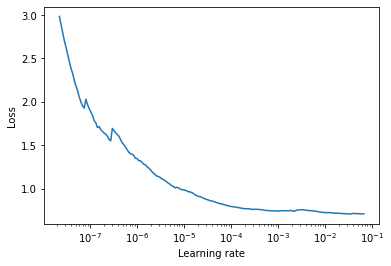

In [26]:
#lr_finder.reset()
lr_finder = CustomLRFinder(model, optimizer, criterion, device="cuda")

# seq dataloader / shuffel the dataloader
for refs, train_dl, val_dl in zip (refs_list, train_dls, valid_dls):
    custom_train_iter = CustomTrainIter(train_dl)
    custom_val_iter = CustomValIter(val_dl)
lr_finder.custom_range_test(custom_train_iter, curr_refs = refs, end_lr=0.1, num_iter=200)
lr_finder.plot(suggest_lr = False)
lr_finder.reset()

In [27]:
num_epochs = 50

lr = 0.000316

min_lr_factor = 0.1
phases_ratio = [0.3, 0.2, 0.3, 0.2]

train_dl_idx = 0
valid_dl_idx = 1
test_dl_idx = 2

run_train = True

net_path = "../MA/save_net/"
criterion = nn.BCELoss()
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']
    
dateTimeObj = datetime.now()
timestampStr = dateTimeObj.strftime("%d-%b-%Y (%H:%M:%S)")
print('Current Timestamp : ', timestampStr)

Current Timestamp :  29-May-2021 (01:01:15)


Total Train Iterations:  380
Total Train Iterations List:  [149, 230, 380]
Valid iterations per seq:  [49, 27, 50]


Train



Sequence:1, Seq Training Mean Loss: 0.7188963230024248, Seq Training Acc: 0.5023070469798657
******************************************************************



Sequence:2, Seq Training Mean Loss: 0.7062967787554235, Seq Training Acc: 0.5173611111111112
******************************************************************



Sequence:3, Seq Training Mean Loss: 0.7039832305908204, Seq Training Acc: 0.509375
******************************************************************
Epoch:1, Epoch Training Loss Mean: 0.7103239297866821, Epoch Training Acc: 0.5083059210526316
******************************************************************
Validation



******************************************************************
Sequence:1, Seq Valid Mean Loss: 0.7193947312783222, Seq Valid Acc: 0.47385204081632654



******************************************************************
Sequence:2, Seq Valid Mean Loss: 0.7105791038937039, Seq Valid Acc: 0.5034722222222222



******************************************************************
Sequence:3, Seq Valid Mean Loss: 0.7128247511386872, Seq Valid Acc: 0.505625
Epoch:1, Epoch Valid Mean Loss: 0.714898407459259, Epoch Valid Acc: 0.4928075396825397
******************************************************************


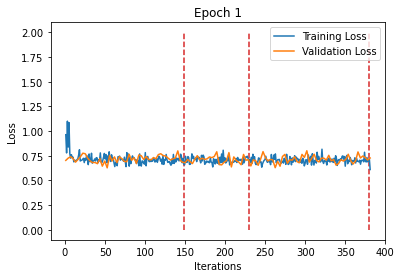

Train



Sequence:1, Seq Training Mean Loss: 0.7023784530242817, Seq Training Acc: 0.5062919463087249
******************************************************************



Sequence:2, Seq Training Mean Loss: 0.7024676012404171, Seq Training Acc: 0.49459876543209874
******************************************************************



Sequence:3, Seq Training Mean Loss: 0.7010981392860413, Seq Training Acc: 0.5035416666666667
******************************************************************
Epoch:2, Epoch Training Loss Mean: 0.701892077922821, Epoch Training Acc: 0.5027138157894737
******************************************************************
Validation



******************************************************************
Sequence:1, Seq Valid Mean Loss: 0.7105934510425646, Seq Valid Acc: 0.5133928571428571



******************************************************************
Sequence:2, Seq Valid Mean Loss: 0.6944666880148428, Seq Valid Acc: 0.5347222222222222



******************************************************************
Sequence:3, Seq Valid Mean Loss: 0.6923036801815033, Seq Valid Acc: 0.538125
Epoch:2, Epoch Valid Mean Loss: 0.6998798251152039, Epoch Valid Acc: 0.5277777777777778
******************************************************************


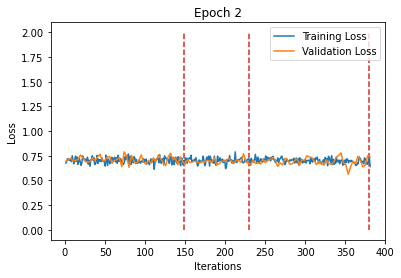

Train



Sequence:1, Seq Training Mean Loss: 0.6979663312035119, Seq Training Acc: 0.5174077181208053
******************************************************************



Sequence:2, Seq Training Mean Loss: 0.6931295968868114, Seq Training Acc: 0.5285493827160493
******************************************************************



Sequence:3, Seq Training Mean Loss: 0.6604897125562033, Seq Training Acc: 0.5922916666666667
******************************************************************
Epoch:3, Epoch Training Loss Mean: 0.6821420192718506, Epoch Training Acc: 0.5493421052631579
******************************************************************
Validation



******************************************************************
Sequence:1, Seq Valid Mean Loss: 0.7141780013940773, Seq Valid Acc: 0.4846938775510204



******************************************************************
Sequence:2, Seq Valid Mean Loss: 0.7084644171926711, Seq Valid Acc: 0.5289351851851852



******************************************************************
Sequence:3, Seq Valid Mean Loss: 0.5765079456567764, Seq Valid Acc: 0.704375
Epoch:3, Epoch Valid Mean Loss: 0.6583226323127747, Epoch Valid Acc: 0.5813492063492064
******************************************************************


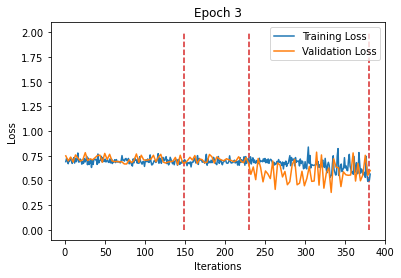

Train



Sequence:1, Seq Training Mean Loss: 0.679709498514265, Seq Training Acc: 0.5643875838926175
******************************************************************



Sequence:2, Seq Training Mean Loss: 0.6819918795868203, Seq Training Acc: 0.5625
******************************************************************



Sequence:3, Seq Training Mean Loss: 0.5690027419726054, Seq Training Acc: 0.695
******************************************************************
Epoch:4, Epoch Training Loss Mean: 0.6364959478378296, Epoch Training Acc: 0.6155427631578947
******************************************************************
Validation



******************************************************************
Sequence:1, Seq Valid Mean Loss: 0.6943387656795735, Seq Valid Acc: 0.5267857142857143



******************************************************************
Sequence:2, Seq Valid Mean Loss: 0.704216738541921, Seq Valid Acc: 0.4988425925925926



******************************************************************
Sequence:3, Seq Valid Mean Loss: 0.49591263115406037, Seq Valid Acc: 0.798125
Epoch:4, Epoch Valid Mean Loss: 0.6177148818969727, Epoch Valid Acc: 0.6284722222222222
******************************************************************


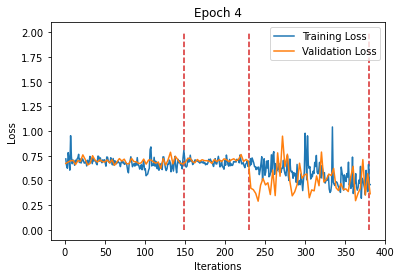

Train



Sequence:1, Seq Training Mean Loss: 0.6481312673363909, Seq Training Acc: 0.6298238255033557
******************************************************************



Sequence:2, Seq Training Mean Loss: 0.6599522549429058, Seq Training Acc: 0.6215277777777778
******************************************************************



Sequence:3, Seq Training Mean Loss: 0.527804200053215, Seq Training Acc: 0.739375
******************************************************************
Epoch:5, Epoch Training Loss Mean: 0.6031534075737, Epoch Training Acc: 0.6712993421052632
******************************************************************
Validation



******************************************************************
Sequence:1, Seq Valid Mean Loss: 0.7013537506667935, Seq Valid Acc: 0.5331632653061225



******************************************************************
Sequence:2, Seq Valid Mean Loss: 0.7356420954068502, Seq Valid Acc: 0.4409722222222222



******************************************************************
Sequence:3, Seq Valid Mean Loss: 0.4052815425395966, Seq Valid Acc: 0.835625
Epoch:5, Epoch Valid Mean Loss: 0.591212272644043, Epoch Valid Acc: 0.6334325396825397
******************************************************************


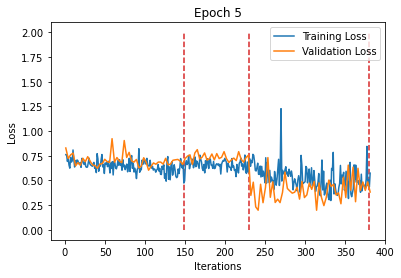

Train



Sequence:1, Seq Training Mean Loss: 0.5911482876579234, Seq Training Acc: 0.6904362416107382
******************************************************************



Sequence:2, Seq Training Mean Loss: 0.6281658072530487, Seq Training Acc: 0.6570216049382716
******************************************************************



Sequence:3, Seq Training Mean Loss: 0.457323668996493, Seq Training Acc: 0.7827083333333333
******************************************************************
Epoch:6, Epoch Training Loss Mean: 0.5462133884429932, Epoch Training Acc: 0.7197368421052631
******************************************************************
Validation



******************************************************************
Sequence:1, Seq Valid Mean Loss: 0.6936836814393803, Seq Valid Acc: 0.5165816326530612



******************************************************************
Sequence:2, Seq Valid Mean Loss: 0.7497409052318997, Seq Valid Acc: 0.4513888888888889



******************************************************************
Sequence:3, Seq Valid Mean Loss: 0.41879011899232865, Seq Valid Acc: 0.83
Epoch:6, Epoch Valid Mean Loss: 0.5966112017631531, Epoch Valid Acc: 0.626984126984127
******************************************************************


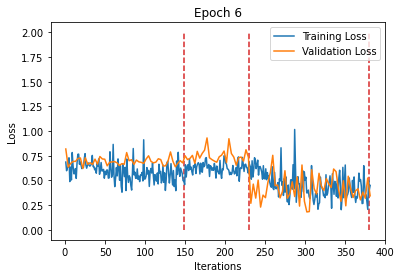

Train



Sequence:1, Seq Training Mean Loss: 0.5060484261320741, Seq Training Acc: 0.7512583892617449
******************************************************************



Sequence:2, Seq Training Mean Loss: 0.594290872046977, Seq Training Acc: 0.6890432098765432
******************************************************************



Sequence:3, Seq Training Mean Loss: 0.4547063293059667, Seq Training Acc: 0.7872916666666666
******************************************************************
Epoch:7, Epoch Training Loss Mean: 0.5045913457870483, Epoch Training Acc: 0.7522203947368421
******************************************************************
Validation



******************************************************************
Sequence:1, Seq Valid Mean Loss: 0.6386058756283352, Seq Valid Acc: 0.6575255102040817



******************************************************************
Sequence:2, Seq Valid Mean Loss: 0.7979797654681735, Seq Valid Acc: 0.5081018518518519



******************************************************************
Sequence:3, Seq Valid Mean Loss: 0.4344560378789902, Seq Valid Acc: 0.8275
Epoch:7, Epoch Valid Mean Loss: 0.5917456746101379, Epoch Valid Acc: 0.6929563492063492
******************************************************************


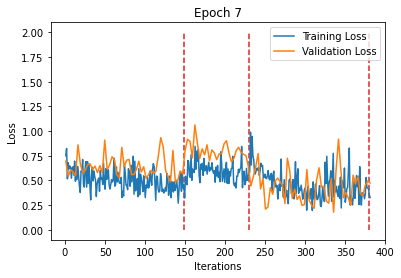

Train



Sequence:1, Seq Training Mean Loss: 0.49666158884963735, Seq Training Acc: 0.7602768456375839
******************************************************************



Sequence:2, Seq Training Mean Loss: 0.5550647392685031, Seq Training Acc: 0.7249228395061729
******************************************************************



Sequence:3, Seq Training Mean Loss: 0.4863288122415543, Seq Training Acc: 0.7629166666666667
******************************************************************
Epoch:8, Epoch Training Loss Mean: 0.505031943321228, Epoch Training Acc: 0.7537828947368421
******************************************************************
Validation



******************************************************************
Sequence:1, Seq Valid Mean Loss: 0.5865424512600412, Seq Valid Acc: 0.7117346938775511



******************************************************************
Sequence:2, Seq Valid Mean Loss: 0.871836315702509, Seq Valid Acc: 0.5196759259259259



******************************************************************
Sequence:3, Seq Valid Mean Loss: 0.5164293774962425, Seq Valid Acc: 0.826875
Epoch:8, Epoch Valid Mean Loss: 0.619854211807251, Epoch Valid Acc: 0.7162698412698413
******************************************************************


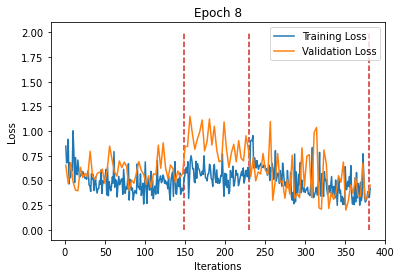

Train



Sequence:1, Seq Training Mean Loss: 0.439792668659415, Seq Training Acc: 0.7980285234899329
******************************************************************



Sequence:2, Seq Training Mean Loss: 0.5331139163470563, Seq Training Acc: 0.7415123456790124
******************************************************************



Sequence:3, Seq Training Mean Loss: 0.4785531733433406, Seq Training Acc: 0.764375
******************************************************************
Epoch:9, Epoch Training Loss Mean: 0.4749850332736969, Epoch Training Acc: 0.7726973684210526
******************************************************************
Validation



******************************************************************
Sequence:1, Seq Valid Mean Loss: 0.7555359370854436, Seq Valid Acc: 0.6128826530612245



******************************************************************
Sequence:2, Seq Valid Mean Loss: 0.9491768015755547, Seq Valid Acc: 0.5289351851851852



******************************************************************
Sequence:3, Seq Valid Mean Loss: 0.5030610182881355, Seq Valid Acc: 0.804375
Epoch:9, Epoch Valid Mean Loss: 0.6968419551849365, Epoch Valid Acc: 0.6708829365079365
******************************************************************


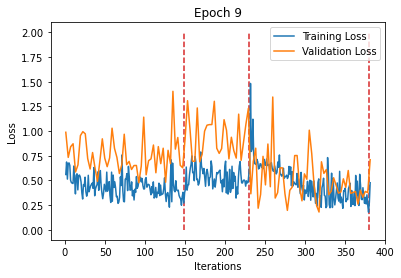

Train



Sequence:1, Seq Training Mean Loss: 0.44574237869889943, Seq Training Acc: 0.791736577181208
******************************************************************



Sequence:2, Seq Training Mean Loss: 0.5442346268230014, Seq Training Acc: 0.7337962962962963
******************************************************************



Sequence:3, Seq Training Mean Loss: 0.4499961072206497, Seq Training Acc: 0.7810416666666666
******************************************************************
Epoch:10, Epoch Training Loss Mean: 0.46841588616371155, Epoch Training Acc: 0.7751644736842105
******************************************************************
Validation



******************************************************************
Sequence:1, Seq Valid Mean Loss: 0.6033394950993207, Seq Valid Acc: 0.7315051020408163



******************************************************************
Sequence:2, Seq Valid Mean Loss: 0.9985221580222801, Seq Valid Acc: 0.5682870370370371



******************************************************************
Sequence:3, Seq Valid Mean Loss: 0.4028977969288826, Seq Valid Acc: 0.828125
Epoch:10, Epoch Valid Mean Loss: 0.6084811091423035, Epoch Valid Acc: 0.7348710317460317
******************************************************************


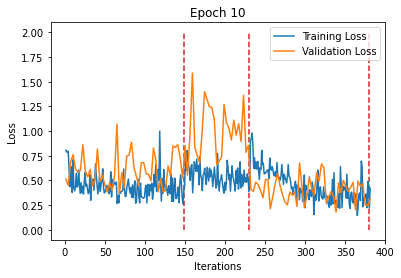

Train



Sequence:1, Seq Training Mean Loss: 0.3923472559092029, Seq Training Acc: 0.8221476510067114
******************************************************************



Sequence:2, Seq Training Mean Loss: 0.5241162651850854, Seq Training Acc: 0.7418981481481481
******************************************************************



Sequence:3, Seq Training Mean Loss: 0.3706283101439476, Seq Training Acc: 0.8295833333333333
******************************************************************
Epoch:11, Epoch Training Loss Mean: 0.4118616282939911, Epoch Training Acc: 0.8079769736842105
******************************************************************
Validation



******************************************************************
Sequence:1, Seq Valid Mean Loss: 0.7084114350834672, Seq Valid Acc: 0.6964285714285714



******************************************************************
Sequence:2, Seq Valid Mean Loss: 1.0760556989245944, Seq Valid Acc: 0.5196759259259259



******************************************************************
Sequence:3, Seq Valid Mean Loss: 0.2827493536472321, Seq Valid Acc: 0.88625
Epoch:11, Epoch Valid Mean Loss: 0.6182788014411926, Epoch Valid Acc: 0.7338789682539683
******************************************************************


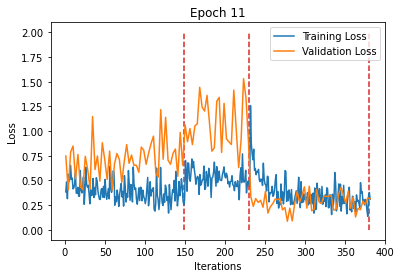

Train



Sequence:1, Seq Training Mean Loss: 0.35134062120978465, Seq Training Acc: 0.8393456375838926
******************************************************************



Sequence:2, Seq Training Mean Loss: 0.4941414984655969, Seq Training Acc: 0.7631172839506173
******************************************************************



Sequence:3, Seq Training Mean Loss: 0.31646322096387547, Seq Training Acc: 0.8529166666666667
******************************************************************
Epoch:12, Epoch Training Loss Mean: 0.36801236867904663, Epoch Training Acc: 0.828453947368421
******************************************************************
Validation



******************************************************************
Sequence:1, Seq Valid Mean Loss: 0.8528125024571711, Seq Valid Acc: 0.6549744897959183



******************************************************************
Sequence:2, Seq Valid Mean Loss: 1.1133801605966356, Seq Valid Acc: 0.5219907407407407



******************************************************************
Sequence:3, Seq Valid Mean Loss: 0.27775109961628913, Seq Valid Acc: 0.8775
Epoch:12, Epoch Valid Mean Loss: 0.680449366569519, Epoch Valid Acc: 0.714781746031746
******************************************************************


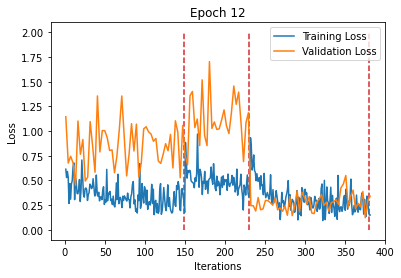

Train



Sequence:1, Seq Training Mean Loss: 0.3359473931709392, Seq Training Acc: 0.8454278523489933
******************************************************************



Sequence:2, Seq Training Mean Loss: 0.46417546419449796, Seq Training Acc: 0.7696759259259259
******************************************************************



Sequence:3, Seq Training Mean Loss: 0.2580384736259778, Seq Training Acc: 0.8866666666666667
******************************************************************
Epoch:13, Epoch Training Loss Mean: 0.33252671360969543, Epoch Training Acc: 0.8455592105263158
******************************************************************
Validation



******************************************************************
Sequence:1, Seq Valid Mean Loss: 0.8381801807150548, Seq Valid Acc: 0.6415816326530612



******************************************************************
Sequence:2, Seq Valid Mean Loss: 0.8949399568416454, Seq Valid Acc: 0.5740740740740741



******************************************************************
Sequence:3, Seq Valid Mean Loss: 0.22501187711954118, Seq Valid Acc: 0.89375
Epoch:13, Epoch Valid Mean Loss: 0.607022225856781, Epoch Valid Acc: 0.7271825396825397
******************************************************************


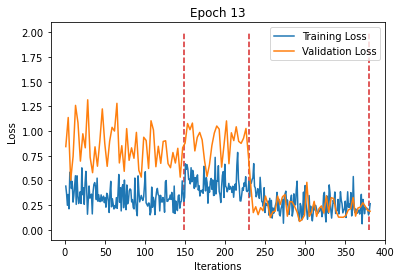

Train



Sequence:1, Seq Training Mean Loss: 0.30059309658788197, Seq Training Acc: 0.8626258389261745
******************************************************************



Sequence:2, Seq Training Mean Loss: 0.4193749048827607, Seq Training Acc: 0.8070987654320988
******************************************************************



Sequence:3, Seq Training Mean Loss: 0.2635617027183374, Seq Training Acc: 0.885625
******************************************************************
Epoch:14, Epoch Training Loss Mean: 0.3112947344779968, Epoch Training Acc: 0.8598684210526316
******************************************************************
Validation



******************************************************************
Sequence:1, Seq Valid Mean Loss: 0.5472738475215678, Seq Valid Acc: 0.7442602040816326



******************************************************************
Sequence:2, Seq Valid Mean Loss: 0.7779385193630501, Seq Valid Acc: 0.6307870370370371



******************************************************************
Sequence:3, Seq Valid Mean Loss: 0.2421588870882988, Seq Valid Acc: 0.9
Epoch:14, Epoch Valid Mean Loss: 0.4756246507167816, Epoch Valid Acc: 0.7817460317460317
******************************************************************


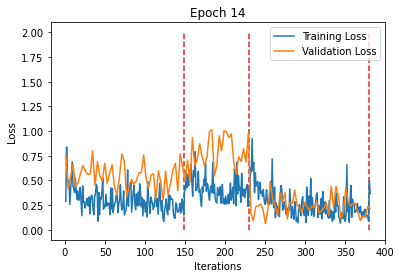

Train



Sequence:1, Seq Training Mean Loss: 0.2986074359024931, Seq Training Acc: 0.8594798657718121
******************************************************************



Sequence:2, Seq Training Mean Loss: 0.39591913017225855, Seq Training Acc: 0.8125
******************************************************************



Sequence:3, Seq Training Mean Loss: 0.2147532050559918, Seq Training Acc: 0.9004166666666666
******************************************************************
Epoch:15, Epoch Training Loss Mean: 0.2862498462200165, Epoch Training Acc: 0.865625
******************************************************************
Validation



******************************************************************
Sequence:1, Seq Valid Mean Loss: 0.5904303539772423, Seq Valid Acc: 0.6964285714285714



******************************************************************
Sequence:2, Seq Valid Mean Loss: 0.6417006982697381, Seq Valid Acc: 0.6458333333333334



******************************************************************
Sequence:3, Seq Valid Mean Loss: 0.21490870386362076, Seq Valid Acc: 0.906875
Epoch:15, Epoch Valid Mean Loss: 0.4524002969264984, Epoch Valid Acc: 0.7690972222222222
******************************************************************


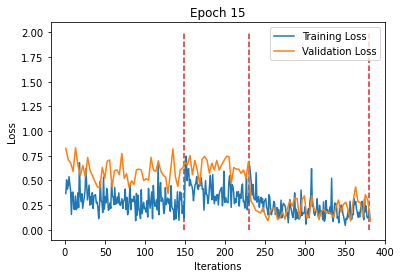

Train



Sequence:1, Seq Training Mean Loss: 0.27524919432881695, Seq Training Acc: 0.8758389261744967
******************************************************************



Sequence:2, Seq Training Mean Loss: 0.4112866627581326, Seq Training Acc: 0.814429012345679
******************************************************************



Sequence:3, Seq Training Mean Loss: 0.2010860032339891, Seq Training Acc: 0.905625
******************************************************************
Epoch:16, Epoch Training Loss Mean: 0.27497172355651855, Epoch Training Acc: 0.8745065789473684
******************************************************************
Validation



******************************************************************
Sequence:1, Seq Valid Mean Loss: 0.5255750064947167, Seq Valid Acc: 0.7576530612244898



******************************************************************
Sequence:2, Seq Valid Mean Loss: 0.9146306338133635, Seq Valid Acc: 0.5914351851851852



******************************************************************
Sequence:3, Seq Valid Mean Loss: 0.1909593293815851, Seq Valid Acc: 0.923125
Epoch:16, Epoch Valid Mean Loss: 0.47616004943847656, Epoch Valid Acc: 0.7876984126984127
******************************************************************


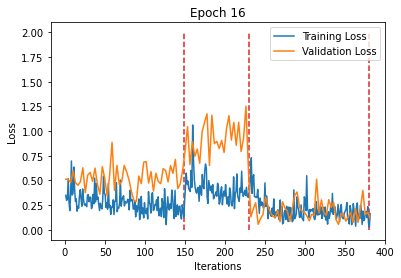

Train



Sequence:1, Seq Training Mean Loss: 0.2745785505179591, Seq Training Acc: 0.87751677852349
******************************************************************



Sequence:2, Seq Training Mean Loss: 0.40281262478710694, Seq Training Acc: 0.8070987654320988
******************************************************************



Sequence:3, Seq Training Mean Loss: 0.19978685607512792, Seq Training Acc: 0.9158333333333334
******************************************************************
Epoch:17, Epoch Training Loss Mean: 0.27238962054252625, Epoch Training Acc: 0.8776315789473684
******************************************************************
Validation



******************************************************************
Sequence:1, Seq Valid Mean Loss: 0.6949951204718375, Seq Valid Acc: 0.6441326530612245



******************************************************************
Sequence:2, Seq Valid Mean Loss: 0.7004391286108229, Seq Valid Acc: 0.6331018518518519



******************************************************************
Sequence:3, Seq Valid Mean Loss: 0.19711434587836266, Seq Valid Acc: 0.91625
Epoch:17, Epoch Valid Mean Loss: 0.49858996272087097, Epoch Valid Acc: 0.7497519841269841
******************************************************************


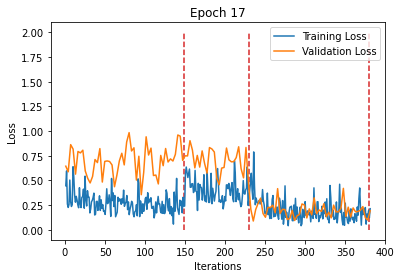

Train



Sequence:1, Seq Training Mean Loss: 0.26873471592896736, Seq Training Acc: 0.8856963087248322
******************************************************************



Sequence:2, Seq Training Mean Loss: 0.3989039920730355, Seq Training Acc: 0.816358024691358
******************************************************************



Sequence:3, Seq Training Mean Loss: 0.18106988772749902, Seq Training Acc: 0.9239583333333333
******************************************************************
Epoch:18, Epoch Training Loss Mean: 0.26187679171562195, Epoch Training Acc: 0.8860197368421052
******************************************************************
Validation



******************************************************************
Sequence:1, Seq Valid Mean Loss: 0.8311505086567937, Seq Valid Acc: 0.6645408163265306



******************************************************************
Sequence:2, Seq Valid Mean Loss: 0.5769248361940738, Seq Valid Acc: 0.7118055555555556



******************************************************************
Sequence:3, Seq Valid Mean Loss: 0.18356308348476888, Seq Valid Acc: 0.92125
Epoch:18, Epoch Valid Mean Loss: 0.5196943879127502, Epoch Valid Acc: 0.7765376984126984
******************************************************************


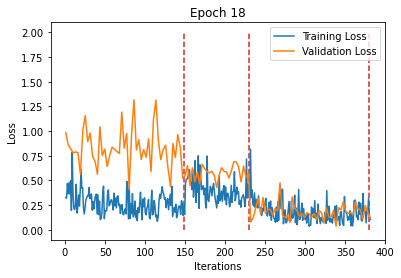

Train



Sequence:1, Seq Training Mean Loss: 0.25165056432253563, Seq Training Acc: 0.8808724832214765
******************************************************************



Sequence:2, Seq Training Mean Loss: 0.35670466868229855, Seq Training Acc: 0.8267746913580247
******************************************************************



Sequence:3, Seq Training Mean Loss: 0.18153984711815913, Seq Training Acc: 0.925
******************************************************************
Epoch:19, Epoch Training Loss Mean: 0.246368408203125, Epoch Training Acc: 0.8867598684210526
******************************************************************
Validation



******************************************************************
Sequence:1, Seq Valid Mean Loss: 0.48930955906303564, Seq Valid Acc: 0.7576530612244898



******************************************************************
Sequence:2, Seq Valid Mean Loss: 0.7058395953090103, Seq Valid Acc: 0.6354166666666666



******************************************************************
Sequence:3, Seq Valid Mean Loss: 0.19443268038332462, Seq Valid Acc: 0.911875
Epoch:19, Epoch Valid Mean Loss: 0.4186941981315613, Epoch Valid Acc: 0.7926587301587301
******************************************************************


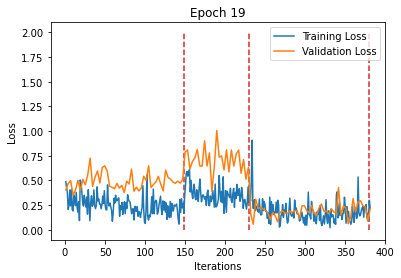

Train



Sequence:1, Seq Training Mean Loss: 0.2524691469617338, Seq Training Acc: 0.8865352348993288
******************************************************************



Sequence:2, Seq Training Mean Loss: 0.34848987725045943, Seq Training Acc: 0.8341049382716049
******************************************************************



Sequence:3, Seq Training Mean Loss: 0.1872679827362299, Seq Training Acc: 0.9129166666666667
******************************************************************
Epoch:20, Epoch Training Loss Mean: 0.2471994161605835, Epoch Training Acc: 0.8857730263157895
******************************************************************
Validation



******************************************************************
Sequence:1, Seq Valid Mean Loss: 0.6193717851930735, Seq Valid Acc: 0.6983418367346939



******************************************************************
Sequence:2, Seq Valid Mean Loss: 0.6079610652393765, Seq Valid Acc: 0.6539351851851852



******************************************************************
Sequence:3, Seq Valid Mean Loss: 0.14984440211206673, Seq Valid Acc: 0.936875
Epoch:20, Epoch Valid Mean Loss: 0.43060624599456787, Epoch Valid Acc: 0.7834821428571429
******************************************************************


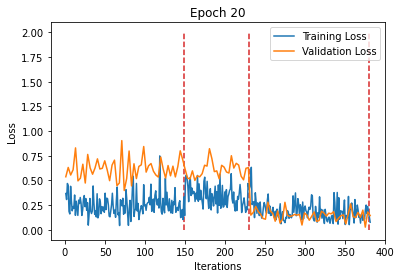

Train



Sequence:1, Seq Training Mean Loss: 0.24358046664887625, Seq Training Acc: 0.8905201342281879
******************************************************************



Sequence:2, Seq Training Mean Loss: 0.35541985910615803, Seq Training Acc: 0.8279320987654321
******************************************************************



Sequence:3, Seq Training Mean Loss: 0.17265547054509323, Seq Training Acc: 0.92375
******************************************************************
Epoch:21, Epoch Training Loss Mean: 0.2394232153892517, Epoch Training Acc: 0.890296052631579
******************************************************************
Validation



******************************************************************
Sequence:1, Seq Valid Mean Loss: 0.4367691241965002, Seq Valid Acc: 0.7895408163265306



******************************************************************
Sequence:2, Seq Valid Mean Loss: 0.5565954932460079, Seq Valid Acc: 0.7395833333333334



******************************************************************
Sequence:3, Seq Valid Mean Loss: 0.2048533783107996, Seq Valid Acc: 0.91
Epoch:21, Epoch Valid Mean Loss: 0.3704161047935486, Epoch Valid Acc: 0.8266369047619048
******************************************************************


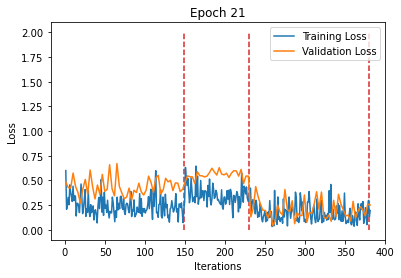

Train



Sequence:1, Seq Training Mean Loss: 0.23264348386918138, Seq Training Acc: 0.8949244966442953
******************************************************************



Sequence:2, Seq Training Mean Loss: 0.3676148193118013, Seq Training Acc: 0.8368055555555556
******************************************************************



Sequence:3, Seq Training Mean Loss: 0.14902635561923186, Seq Training Acc: 0.9308333333333333
******************************************************************
Epoch:22, Epoch Training Loss Mean: 0.22840692102909088, Epoch Training Acc: 0.8967105263157895
******************************************************************
Validation



******************************************************************
Sequence:1, Seq Valid Mean Loss: 0.6229764886048376, Seq Valid Acc: 0.7283163265306123



******************************************************************
Sequence:2, Seq Valid Mean Loss: 0.5121478747438502, Seq Valid Acc: 0.7418981481481481



******************************************************************
Sequence:3, Seq Valid Mean Loss: 0.183624367415905, Seq Valid Acc: 0.93125
Epoch:22, Epoch Valid Mean Loss: 0.4248814284801483, Epoch Valid Acc: 0.8117559523809523
******************************************************************


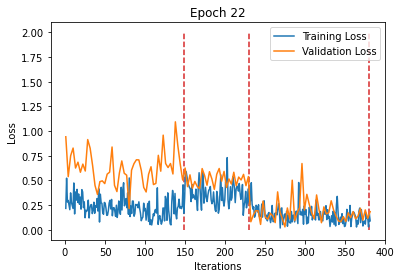

Train



Sequence:1, Seq Training Mean Loss: 0.25283749436572095, Seq Training Acc: 0.888003355704698
******************************************************************



Sequence:2, Seq Training Mean Loss: 0.33360142251591623, Seq Training Acc: 0.84375
******************************************************************



Sequence:3, Seq Training Mean Loss: 0.15450503796339035, Seq Training Acc: 0.9308333333333333
******************************************************************
Epoch:23, Epoch Training Loss Mean: 0.2312375158071518, Epoch Training Acc: 0.8954769736842105
******************************************************************
Validation



******************************************************************
Sequence:1, Seq Valid Mean Loss: 0.3059772925109279, Seq Valid Acc: 0.8628826530612245



******************************************************************
Sequence:2, Seq Valid Mean Loss: 0.5466755871419553, Seq Valid Acc: 0.7569444444444444



******************************************************************
Sequence:3, Seq Valid Mean Loss: 0.16471068918704987, Seq Valid Acc: 0.924375
Epoch:23, Epoch Valid Mean Loss: 0.30149731040000916, Epoch Valid Acc: 0.8645833333333334
******************************************************************


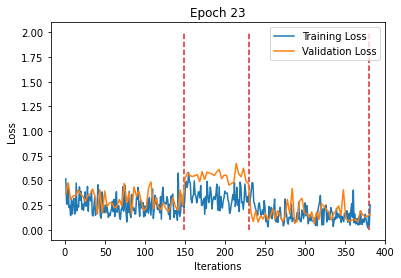

Train



Sequence:1, Seq Training Mean Loss: 0.24074169348350308, Seq Training Acc: 0.8917785234899329
******************************************************************



Sequence:2, Seq Training Mean Loss: 0.3154636360244987, Seq Training Acc: 0.8572530864197531
******************************************************************



Sequence:3, Seq Training Mean Loss: 0.14786832300325234, Seq Training Acc: 0.9358333333333333
******************************************************************
Epoch:24, Epoch Training Loss Mean: 0.2200087308883667, Epoch Training Acc: 0.9018092105263158
******************************************************************
Validation



******************************************************************
Sequence:1, Seq Valid Mean Loss: 0.4321636314294776, Seq Valid Acc: 0.7818877551020408



******************************************************************
Sequence:2, Seq Valid Mean Loss: 0.5462859637207456, Seq Valid Acc: 0.7662037037037037



******************************************************************
Sequence:3, Seq Valid Mean Loss: 0.13752916004508733, Seq Valid Acc: 0.943125
Epoch:24, Epoch Valid Mean Loss: 0.339699923992157, Epoch Valid Acc: 0.8425099206349206
******************************************************************


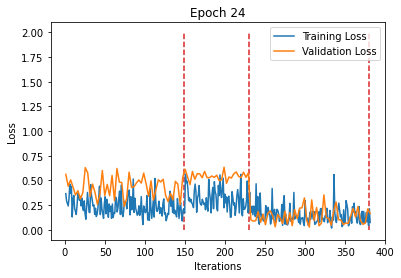

Train



Sequence:1, Seq Training Mean Loss: 0.23778322454066886, Seq Training Acc: 0.9010067114093959
******************************************************************



Sequence:2, Seq Training Mean Loss: 0.3012790893330986, Seq Training Acc: 0.8684413580246914
******************************************************************



Sequence:3, Seq Training Mean Loss: 0.14669336018462975, Seq Training Acc: 0.9370833333333334
******************************************************************
Epoch:25, Epoch Training Loss Mean: 0.2153613418340683, Epoch Training Acc: 0.9083059210526315
******************************************************************
Validation



******************************************************************
Sequence:1, Seq Valid Mean Loss: 0.31209942455194434, Seq Valid Acc: 0.8494897959183674



******************************************************************
Sequence:2, Seq Valid Mean Loss: 0.4740273411627169, Seq Valid Acc: 0.7881944444444444



******************************************************************
Sequence:3, Seq Valid Mean Loss: 0.1284204762801528, Seq Valid Acc: 0.939375
Epoch:25, Epoch Valid Mean Loss: 0.2739098072052002, Epoch Valid Acc: 0.8720238095238095
******************************************************************


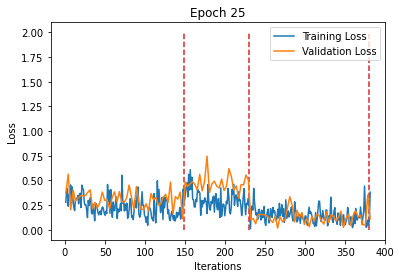

Train



Sequence:1, Seq Training Mean Loss: 0.2340105114467192, Seq Training Acc: 0.8934563758389261
******************************************************************



Sequence:2, Seq Training Mean Loss: 0.2909062028299143, Seq Training Acc: 0.8742283950617284
******************************************************************



Sequence:3, Seq Training Mean Loss: 0.13249439866592486, Seq Training Acc: 0.9425
******************************************************************
Epoch:26, Epoch Training Loss Mean: 0.20606613159179688, Epoch Training Acc: 0.9087171052631579
******************************************************************
Validation



******************************************************************
Sequence:1, Seq Valid Mean Loss: 0.345684541123254, Seq Valid Acc: 0.8335459183673469



******************************************************************
Sequence:2, Seq Valid Mean Loss: 0.592302840065073, Seq Valid Acc: 0.6736111111111112



******************************************************************
Sequence:3, Seq Valid Mean Loss: 0.13400977186858654, Seq Valid Acc: 0.943125
Epoch:26, Epoch Valid Mean Loss: 0.31453341245651245, Epoch Valid Acc: 0.8427579365079365
******************************************************************


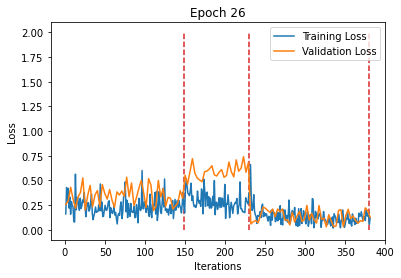

Train



Sequence:1, Seq Training Mean Loss: 0.22533779406307528, Seq Training Acc: 0.894505033557047
******************************************************************



Sequence:2, Seq Training Mean Loss: 0.30297709265608846, Seq Training Acc: 0.8661265432098766
******************************************************************



Sequence:3, Seq Training Mean Loss: 0.1335465926428636, Seq Training Acc: 0.9408333333333333
******************************************************************
Epoch:27, Epoch Training Loss Mean: 0.2056538611650467, Epoch Training Acc: 0.9067434210526316
******************************************************************
Validation



******************************************************************
Sequence:1, Seq Valid Mean Loss: 0.36941088279899287, Seq Valid Acc: 0.8354591836734694



******************************************************************
Sequence:2, Seq Valid Mean Loss: 0.463760550375338, Seq Valid Acc: 0.7754629629629629



******************************************************************
Sequence:3, Seq Valid Mean Loss: 0.12671401895582676, Seq Valid Acc: 0.9525
Epoch:27, Epoch Valid Mean Loss: 0.29332035779953003, Epoch Valid Acc: 0.8690476190476191
******************************************************************


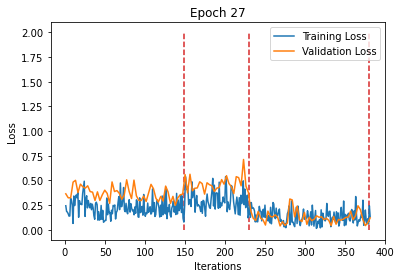

Train



Sequence:1, Seq Training Mean Loss: 0.21855888780731483, Seq Training Acc: 0.9010067114093959
******************************************************************



Sequence:2, Seq Training Mean Loss: 0.2891814237759437, Seq Training Acc: 0.8761574074074074
******************************************************************



Sequence:3, Seq Training Mean Loss: 0.134149903661261, Seq Training Acc: 0.9435416666666666
******************************************************************
Epoch:28, Epoch Training Loss Mean: 0.20029331743717194, Epoch Training Acc: 0.9125
******************************************************************
Validation



******************************************************************
Sequence:1, Seq Valid Mean Loss: 0.3072658105164158, Seq Valid Acc: 0.8596938775510204



******************************************************************
Sequence:2, Seq Valid Mean Loss: 0.44565292861726546, Seq Valid Acc: 0.8194444444444444



******************************************************************
Sequence:3, Seq Valid Mean Loss: 0.10415333125740289, Seq Valid Acc: 0.960625
Epoch:28, Epoch Valid Mean Loss: 0.25631996989250183, Epoch Valid Acc: 0.8911210317460317
******************************************************************


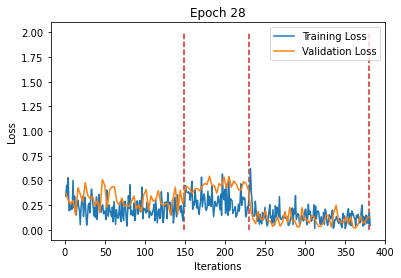

Train



Sequence:1, Seq Training Mean Loss: 0.2143020298356978, Seq Training Acc: 0.9018456375838926
******************************************************************



Sequence:2, Seq Training Mean Loss: 0.30044141237014604, Seq Training Acc: 0.8653549382716049
******************************************************************



Sequence:3, Seq Training Mean Loss: 0.11785034195830425, Seq Training Acc: 0.9483333333333334
******************************************************************
Epoch:29, Epoch Training Loss Mean: 0.1945902705192566, Epoch Training Acc: 0.9124177631578947
******************************************************************
Validation



******************************************************************
Sequence:1, Seq Valid Mean Loss: 0.484617253347319, Seq Valid Acc: 0.7914540816326531



******************************************************************
Sequence:2, Seq Valid Mean Loss: 0.7335589671576465, Seq Valid Acc: 0.6643518518518519



******************************************************************
Sequence:3, Seq Valid Mean Loss: 0.11382552370429039, Seq Valid Acc: 0.95375
Epoch:29, Epoch Valid Mean Loss: 0.39082229137420654, Epoch Valid Acc: 0.8286210317460317
******************************************************************


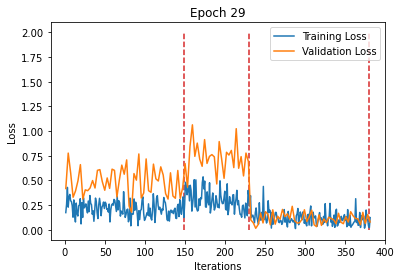

Train



Sequence:1, Seq Training Mean Loss: 0.20368254762267907, Seq Training Acc: 0.9075083892617449
******************************************************************



Sequence:2, Seq Training Mean Loss: 0.2734484911700826, Seq Training Acc: 0.8738425925925926
******************************************************************



Sequence:3, Seq Training Mean Loss: 0.11426510899017255, Seq Training Acc: 0.95
******************************************************************
Epoch:30, Epoch Training Loss Mean: 0.1832573562860489, Epoch Training Acc: 0.9171052631578948
******************************************************************
Validation



******************************************************************
Sequence:1, Seq Valid Mean Loss: 0.4380461561436556, Seq Valid Acc: 0.7857142857142857



******************************************************************
Sequence:2, Seq Valid Mean Loss: 0.4136624899175432, Seq Valid Acc: 0.8159722222222222



******************************************************************
Sequence:3, Seq Valid Mean Loss: 0.11512493707239628, Seq Valid Acc: 0.95
Epoch:30, Epoch Valid Mean Loss: 0.30467772483825684, Epoch Valid Acc: 0.857390873015873
******************************************************************


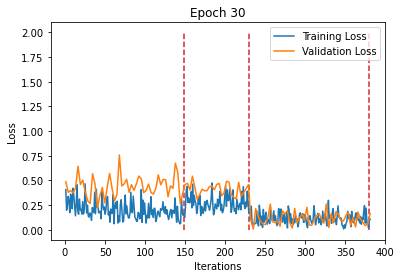

Train



Sequence:1, Seq Training Mean Loss: 0.18861471461569704, Seq Training Acc: 0.9114932885906041
******************************************************************



Sequence:2, Seq Training Mean Loss: 0.2758024553825826, Seq Training Acc: 0.8800154320987654
******************************************************************



Sequence:3, Seq Training Mean Loss: 0.11249006040394306, Seq Training Acc: 0.9508333333333333
******************************************************************
Epoch:31, Epoch Training Loss Mean: 0.17715026438236237, Epoch Training Acc: 0.9203125
******************************************************************
Validation



******************************************************************
Sequence:1, Seq Valid Mean Loss: 0.2781210496109359, Seq Valid Acc: 0.8826530612244898



******************************************************************
Sequence:2, Seq Valid Mean Loss: 0.43001693376788386, Seq Valid Acc: 0.8125



******************************************************************
Sequence:3, Seq Valid Mean Loss: 0.12866138137876987, Seq Valid Acc: 0.946875
Epoch:31, Epoch Valid Mean Loss: 0.2513607442378998, Epoch Valid Acc: 0.8931051587301587
******************************************************************


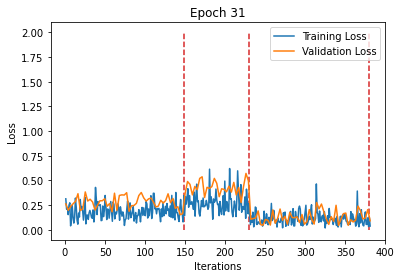

Train



Sequence:1, Seq Training Mean Loss: 0.19179719023956548, Seq Training Acc: 0.916736577181208
******************************************************************



Sequence:2, Seq Training Mean Loss: 0.2566215453876389, Seq Training Acc: 0.8761574074074074
******************************************************************



Sequence:3, Seq Training Mean Loss: 0.11188061580993235, Seq Training Acc: 0.9504166666666667
******************************************************************
Epoch:32, Epoch Training Loss Mean: 0.17406898736953735, Epoch Training Acc: 0.9213815789473684
******************************************************************
Validation



******************************************************************
Sequence:1, Seq Valid Mean Loss: 0.2601580911753129, Seq Valid Acc: 0.8941326530612245



******************************************************************
Sequence:2, Seq Valid Mean Loss: 0.4190872168099439, Seq Valid Acc: 0.8368055555555556



******************************************************************
Sequence:3, Seq Valid Mean Loss: 0.12520229056477547, Seq Valid Acc: 0.94875
Epoch:32, Epoch Valid Mean Loss: 0.24066045880317688, Epoch Valid Acc: 0.9035218253968254
******************************************************************


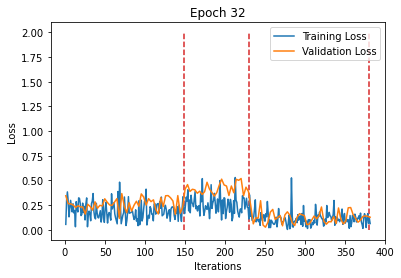

Train



Sequence:1, Seq Training Mean Loss: 0.17961066688767216, Seq Training Acc: 0.9169463087248322
******************************************************************



Sequence:2, Seq Training Mean Loss: 0.2435867938178557, Seq Training Acc: 0.8861882716049383
******************************************************************



Sequence:3, Seq Training Mean Loss: 0.10609935904697826, Seq Training Acc: 0.9508333333333333
******************************************************************
Epoch:33, Epoch Training Loss Mean: 0.16423006355762482, Epoch Training Acc: 0.9237664473684211
******************************************************************
Validation



******************************************************************
Sequence:1, Seq Valid Mean Loss: 0.37937903738751705, Seq Valid Acc: 0.8341836734693877



******************************************************************
Sequence:2, Seq Valid Mean Loss: 0.44499028501687227, Seq Valid Acc: 0.7870370370370371



******************************************************************
Sequence:3, Seq Valid Mean Loss: 0.08812360167503357, Seq Valid Acc: 0.964375
Epoch:33, Epoch Valid Mean Loss: 0.2778610587120056, Epoch Valid Acc: 0.8757440476190477
******************************************************************


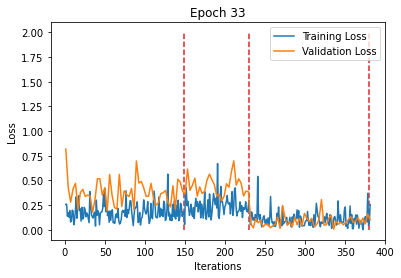

Train



Sequence:1, Seq Training Mean Loss: 0.17995157687856048, Seq Training Acc: 0.9198825503355704
******************************************************************



Sequence:2, Seq Training Mean Loss: 0.24890600715154482, Seq Training Acc: 0.8881172839506173
******************************************************************



Sequence:3, Seq Training Mean Loss: 0.100731612679859, Seq Training Acc: 0.9566666666666667
******************************************************************
Epoch:34, Epoch Training Loss Mean: 0.1633787304162979, Epoch Training Acc: 0.9276315789473685
******************************************************************
Validation



******************************************************************
Sequence:1, Seq Valid Mean Loss: 0.3176576449554794, Seq Valid Acc: 0.857780612244898



******************************************************************
Sequence:2, Seq Valid Mean Loss: 0.4142770866552989, Seq Valid Acc: 0.8159722222222222



******************************************************************
Sequence:3, Seq Valid Mean Loss: 0.1296133952587843, Seq Valid Acc: 0.943125
Epoch:34, Epoch Valid Mean Loss: 0.26374107599258423, Epoch Valid Acc: 0.8826884920634921
******************************************************************


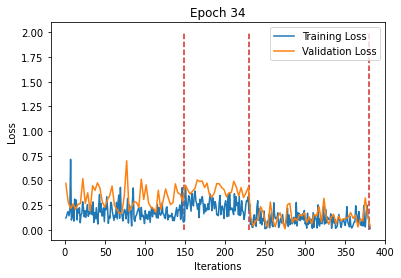

Train



Sequence:1, Seq Training Mean Loss: 0.16902842968952336, Seq Training Acc: 0.928481543624161
******************************************************************



Sequence:2, Seq Training Mean Loss: 0.2193610992880515, Seq Training Acc: 0.904320987654321
******************************************************************



Sequence:3, Seq Training Mean Loss: 0.09251894326259692, Seq Training Acc: 0.9602083333333333
******************************************************************
Epoch:35, Epoch Training Loss Mean: 0.14955611526966095, Epoch Training Acc: 0.9358552631578947
******************************************************************
Validation



******************************************************************
Sequence:1, Seq Valid Mean Loss: 0.20880771778067764, Seq Valid Acc: 0.9024234693877551



******************************************************************
Sequence:2, Seq Valid Mean Loss: 0.4151755317493721, Seq Valid Acc: 0.8043981481481481



******************************************************************
Sequence:3, Seq Valid Mean Loss: 0.07842345338314771, Seq Valid Acc: 0.96625
Epoch:35, Epoch Valid Mean Loss: 0.2012895792722702, Epoch Valid Acc: 0.9067460317460317
******************************************************************


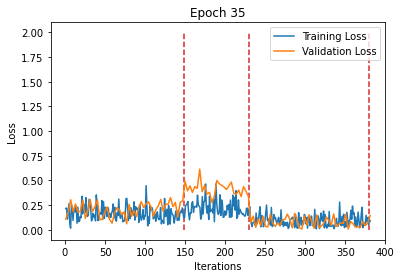

Train



Sequence:1, Seq Training Mean Loss: 0.16252349849615322, Seq Training Acc: 0.9278523489932886
******************************************************************



Sequence:2, Seq Training Mean Loss: 0.20106869761222673, Seq Training Acc: 0.9108796296296297
******************************************************************



Sequence:3, Seq Training Mean Loss: 0.0985072364564985, Seq Training Acc: 0.9552083333333333
******************************************************************
Epoch:36, Epoch Training Loss Mean: 0.14547012746334076, Epoch Training Acc: 0.9350328947368421
******************************************************************
Validation



******************************************************************
Sequence:1, Seq Valid Mean Loss: 0.3028992420556594, Seq Valid Acc: 0.8673469387755102



******************************************************************
Sequence:2, Seq Valid Mean Loss: 0.49769733790998105, Seq Valid Acc: 0.75



******************************************************************
Sequence:3, Seq Valid Mean Loss: 0.1093659037235193, Seq Valid Acc: 0.951875
Epoch:36, Epoch Valid Mean Loss: 0.26784273982048035, Epoch Valid Acc: 0.8757440476190477
******************************************************************


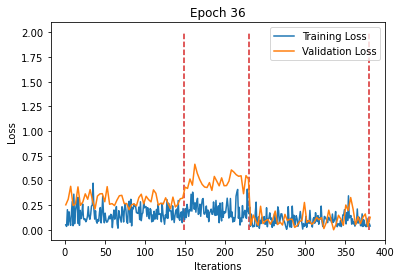

Train



Sequence:1, Seq Training Mean Loss: 0.15568686036655566, Seq Training Acc: 0.9272231543624161
******************************************************************



Sequence:2, Seq Training Mean Loss: 0.20468845825504373, Seq Training Acc: 0.9131944444444444
******************************************************************



Sequence:3, Seq Training Mean Loss: 0.09101071241156508, Seq Training Acc: 0.95875
******************************************************************
Epoch:37, Epoch Training Loss Mean: 0.14060188829898834, Epoch Training Acc: 0.9366776315789473
******************************************************************
Validation



******************************************************************
Sequence:1, Seq Valid Mean Loss: 0.2516174395473636, Seq Valid Acc: 0.8801020408163265



******************************************************************
Sequence:2, Seq Valid Mean Loss: 0.44568546061162595, Seq Valid Acc: 0.7824074074074074



******************************************************************
Sequence:3, Seq Valid Mean Loss: 0.10376743264496327, Seq Valid Acc: 0.95375
Epoch:37, Epoch Valid Mean Loss: 0.23453280329704285, Epoch Valid Acc: 0.8883928571428571
******************************************************************


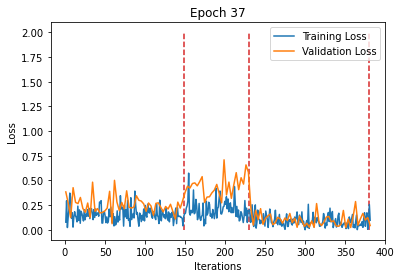

Train



Sequence:1, Seq Training Mean Loss: 0.14991748380480996, Seq Training Acc: 0.9337248322147651
******************************************************************



Sequence:2, Seq Training Mean Loss: 0.2144214719717885, Seq Training Acc: 0.9085648148148148
******************************************************************



Sequence:3, Seq Training Mean Loss: 0.08905574973517408, Seq Training Acc: 0.9604166666666667
******************************************************************
Epoch:38, Epoch Training Loss Mean: 0.1396426409482956, Epoch Training Acc: 0.9388980263157894
******************************************************************
Validation



******************************************************************
Sequence:1, Seq Valid Mean Loss: 0.25382843796087773, Seq Valid Acc: 0.8845663265306123



******************************************************************
Sequence:2, Seq Valid Mean Loss: 0.441504481765959, Seq Valid Acc: 0.8043981481481481



******************************************************************
Sequence:3, Seq Valid Mean Loss: 0.08090094245970249, Seq Valid Acc: 0.968125
Epoch:38, Epoch Valid Mean Loss: 0.2254226952791214, Epoch Valid Acc: 0.9005456349206349
******************************************************************


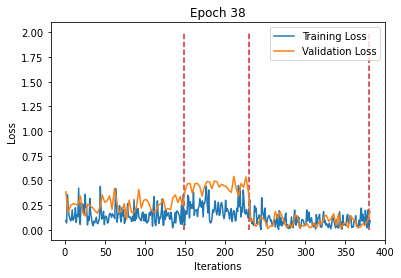

Train



Sequence:1, Seq Training Mean Loss: 0.17071862746305114, Seq Training Acc: 0.920511744966443
******************************************************************



Sequence:2, Seq Training Mean Loss: 0.2000583063489125, Seq Training Acc: 0.9143518518518519
******************************************************************



Sequence:3, Seq Training Mean Loss: 0.07878173215935627, Seq Training Acc: 0.965625
******************************************************************
Epoch:39, Epoch Training Loss Mean: 0.14068174362182617, Epoch Training Acc: 0.9370065789473684
******************************************************************
Validation



******************************************************************
Sequence:1, Seq Valid Mean Loss: 0.21653730878416372, Seq Valid Acc: 0.9030612244897959



******************************************************************
Sequence:2, Seq Valid Mean Loss: 0.3908133131486398, Seq Valid Acc: 0.8321759259259259



******************************************************************
Sequence:3, Seq Valid Mean Loss: 0.10118427469395101, Seq Valid Acc: 0.95875
Epoch:39, Epoch Valid Mean Loss: 0.20810715854167938, Epoch Valid Acc: 0.9099702380952381
******************************************************************


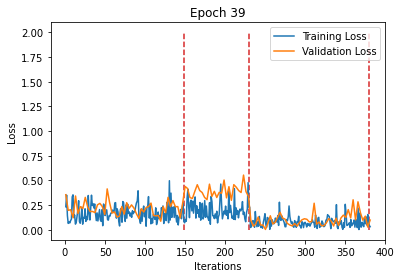

Train



Sequence:1, Seq Training Mean Loss: 0.15242146181830224, Seq Training Acc: 0.9301593959731543
******************************************************************



Sequence:2, Seq Training Mean Loss: 0.19080280461980972, Seq Training Acc: 0.9155092592592593
******************************************************************



Sequence:3, Seq Training Mean Loss: 0.07684560481148461, Seq Training Acc: 0.96625
******************************************************************
Epoch:40, Epoch Training Loss Mean: 0.13077017664909363, Epoch Training Acc: 0.9412828947368421
******************************************************************
Validation



******************************************************************
Sequence:1, Seq Valid Mean Loss: 0.2580748200416565, Seq Valid Acc: 0.8871173469387755



******************************************************************
Sequence:2, Seq Valid Mean Loss: 0.42753881216049194, Seq Valid Acc: 0.7800925925925926



******************************************************************
Sequence:3, Seq Valid Mean Loss: 0.08199165401048958, Seq Valid Acc: 0.9625
Epoch:40, Epoch Valid Mean Loss: 0.22451424598693848, Epoch Valid Acc: 0.8940972222222222
******************************************************************


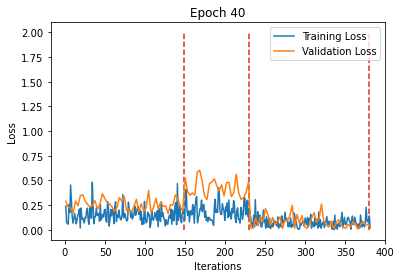

Train



Sequence:1, Seq Training Mean Loss: 0.12295161787070484, Seq Training Acc: 0.946518456375839
******************************************************************



Sequence:2, Seq Training Mean Loss: 0.18728100664821673, Seq Training Acc: 0.9174382716049383
******************************************************************



Sequence:3, Seq Training Mean Loss: 0.06936517883092165, Seq Training Acc: 0.9691666666666666
******************************************************************
Epoch:41, Epoch Training Loss Mean: 0.11551138013601303, Epoch Training Acc: 0.9492598684210526
******************************************************************
Validation



******************************************************************
Sequence:1, Seq Valid Mean Loss: 0.27989677233355387, Seq Valid Acc: 0.8718112244897959



******************************************************************
Sequence:2, Seq Valid Mean Loss: 0.39684182184713857, Seq Valid Acc: 0.8240740740740741



******************************************************************
Sequence:3, Seq Valid Mean Loss: 0.07458144924603402, Seq Valid Acc: 0.971875
Epoch:41, Epoch Valid Mean Loss: 0.22348208725452423, Epoch Valid Acc: 0.9012896825396826
******************************************************************


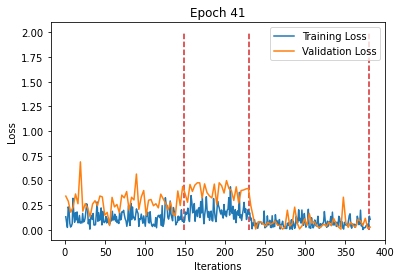

Train



Sequence:1, Seq Training Mean Loss: 0.13489189627736606, Seq Training Acc: 0.9404362416107382
******************************************************************



Sequence:2, Seq Training Mean Loss: 0.16500064749040722, Seq Training Acc: 0.9290123456790124
******************************************************************



Sequence:3, Seq Training Mean Loss: 0.07547051916519801, Seq Training Acc: 0.9652083333333333
******************************************************************
Epoch:42, Epoch Training Loss Mean: 0.11785400658845901, Epoch Training Acc: 0.9477796052631579
******************************************************************
Validation



******************************************************************
Sequence:1, Seq Valid Mean Loss: 0.20921078073431035, Seq Valid Acc: 0.9075255102040817



******************************************************************
Sequence:2, Seq Valid Mean Loss: 0.3630468740507408, Seq Valid Acc: 0.8425925925925926



******************************************************************
Sequence:3, Seq Valid Mean Loss: 0.07739227386191487, Seq Valid Acc: 0.97
Epoch:42, Epoch Valid Mean Loss: 0.18986673653125763, Epoch Valid Acc: 0.9184027777777778
******************************************************************


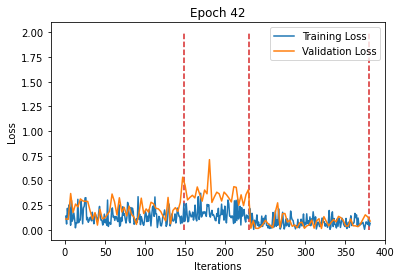

Train



Sequence:1, Seq Training Mean Loss: 0.13468842649669854, Seq Training Acc: 0.9385486577181208
******************************************************************



Sequence:2, Seq Training Mean Loss: 0.17019015431036183, Seq Training Acc: 0.9263117283950617
******************************************************************



Sequence:3, Seq Training Mean Loss: 0.07643794382767131, Seq Training Acc: 0.9660416666666667
******************************************************************
Epoch:43, Epoch Training Loss Mean: 0.11926229298114777, Epoch Training Acc: 0.9467927631578947
******************************************************************
Validation



******************************************************************
Sequence:1, Seq Valid Mean Loss: 0.24832523097189105, Seq Valid Acc: 0.8915816326530612



******************************************************************
Sequence:2, Seq Valid Mean Loss: 0.3403612303513068, Seq Valid Acc: 0.8657407407407407



******************************************************************
Sequence:3, Seq Valid Mean Loss: 0.07872915210202336, Seq Valid Acc: 0.9725
Epoch:43, Epoch Valid Mean Loss: 0.20074719190597534, Epoch Valid Acc: 0.9181547619047619
******************************************************************


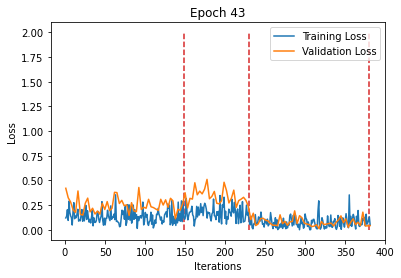

Train



Sequence:1, Seq Training Mean Loss: 0.13020136322976159, Seq Training Acc: 0.9402265100671141
******************************************************************



Sequence:2, Seq Training Mean Loss: 0.17621186210049522, Seq Training Acc: 0.9189814814814815
******************************************************************



Sequence:3, Seq Training Mean Loss: 0.0710024580731988, Seq Training Acc: 0.970625
******************************************************************
Epoch:44, Epoch Training Loss Mean: 0.11664087325334549, Epoch Training Acc: 0.9476973684210527
******************************************************************
Validation



******************************************************************
Sequence:1, Seq Valid Mean Loss: 0.2220082876025414, Seq Valid Acc: 0.8960459183673469



******************************************************************
Sequence:2, Seq Valid Mean Loss: 0.3889345990286933, Seq Valid Acc: 0.8206018518518519



******************************************************************
Sequence:3, Seq Valid Mean Loss: 0.0862924787774682, Seq Valid Acc: 0.963125
Epoch:44, Epoch Valid Mean Loss: 0.20392271876335144, Epoch Valid Acc: 0.9064980158730159
******************************************************************


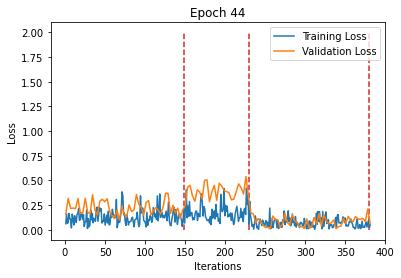

Train



Sequence:1, Seq Training Mean Loss: 0.12559860155936456, Seq Training Acc: 0.9448406040268457
******************************************************************



Sequence:2, Seq Training Mean Loss: 0.15141109998027483, Seq Training Acc: 0.9317129629629629
******************************************************************



Sequence:3, Seq Training Mean Loss: 0.07274670327082276, Seq Training Acc: 0.9702083333333333
******************************************************************
Epoch:45, Epoch Training Loss Mean: 0.11023815721273422, Epoch Training Acc: 0.9520559210526316
******************************************************************
Validation



******************************************************************
Sequence:1, Seq Valid Mean Loss: 0.20437647082975932, Seq Valid Acc: 0.9056122448979592



******************************************************************
Sequence:2, Seq Valid Mean Loss: 0.32337936979753, Seq Valid Acc: 0.8599537037037037



******************************************************************
Sequence:3, Seq Valid Mean Loss: 0.06603532267734408, Seq Valid Acc: 0.973125
Epoch:45, Epoch Valid Mean Loss: 0.1749798059463501, Epoch Valid Acc: 0.9226190476190477
******************************************************************


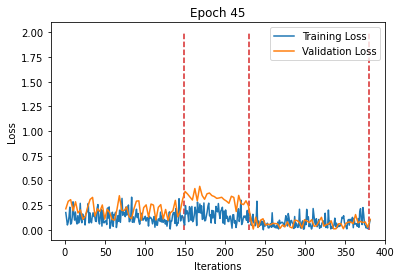

Train



Sequence:1, Seq Training Mean Loss: 0.12381796473824738, Seq Training Acc: 0.946518456375839
******************************************************************



Sequence:2, Seq Training Mean Loss: 0.15296174054620443, Seq Training Acc: 0.9347993827160493
******************************************************************



Sequence:3, Seq Training Mean Loss: 0.07807129836990498, Seq Training Acc: 0.9639583333333334
******************************************************************
Epoch:46, Epoch Training Loss Mean: 0.11197229474782944, Epoch Training Acc: 0.9509046052631579
******************************************************************
Validation



******************************************************************
Sequence:1, Seq Valid Mean Loss: 0.22783236266398915, Seq Valid Acc: 0.9011479591836735



******************************************************************
Sequence:2, Seq Valid Mean Loss: 0.33834697858051016, Seq Valid Acc: 0.8449074074074074



******************************************************************
Sequence:3, Seq Valid Mean Loss: 0.07906612636055797, Seq Valid Acc: 0.96375
Epoch:46, Epoch Valid Mean Loss: 0.19247983396053314, Epoch Valid Acc: 0.9139384920634921
******************************************************************


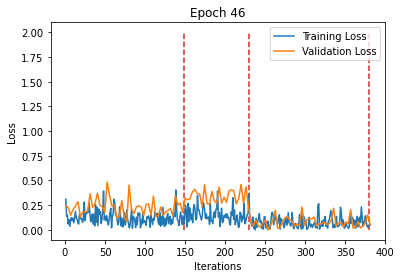

Train



Sequence:1, Seq Training Mean Loss: 0.1272815621189223, Seq Training Acc: 0.9429530201342282
******************************************************************



Sequence:2, Seq Training Mean Loss: 0.17409567691293765, Seq Training Acc: 0.9266975308641975
******************************************************************



Sequence:3, Seq Training Mean Loss: 0.06574697740375995, Seq Training Acc: 0.9720833333333333
******************************************************************
Epoch:47, Epoch Training Loss Mean: 0.11297038942575455, Epoch Training Acc: 0.9509868421052632
******************************************************************
Validation



******************************************************************
Sequence:1, Seq Valid Mean Loss: 0.22188256680965424, Seq Valid Acc: 0.8979591836734694



******************************************************************
Sequence:2, Seq Valid Mean Loss: 0.35185473053543653, Seq Valid Acc: 0.84375



******************************************************************
Sequence:3, Seq Valid Mean Loss: 0.08355752075091004, Seq Valid Acc: 0.96375
Epoch:47, Epoch Valid Mean Loss: 0.1948428601026535, Epoch Valid Acc: 0.9124503968253969
******************************************************************


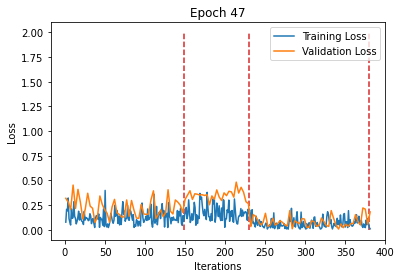

Train



Sequence:1, Seq Training Mean Loss: 0.14513990973066163, Seq Training Acc: 0.93498322147651
******************************************************************



Sequence:2, Seq Training Mean Loss: 0.17731292440015592, Seq Training Acc: 0.9174382716049383
******************************************************************



Sequence:3, Seq Training Mean Loss: 0.07164652609576781, Seq Training Acc: 0.965625
******************************************************************
Epoch:48, Epoch Training Loss Mean: 0.1229873076081276, Epoch Training Acc: 0.9433388157894737
******************************************************************
Validation



******************************************************************
Sequence:1, Seq Valid Mean Loss: 0.22057549244895272, Seq Valid Acc: 0.8934948979591837



******************************************************************
Sequence:2, Seq Valid Mean Loss: 0.3304969480744115, Seq Valid Acc: 0.8634259259259259



******************************************************************
Sequence:3, Seq Valid Mean Loss: 0.08042260576039553, Seq Valid Acc: 0.9675
Epoch:48, Epoch Valid Mean Loss: 0.1885138750076294, Epoch Valid Acc: 0.9164186507936508
******************************************************************


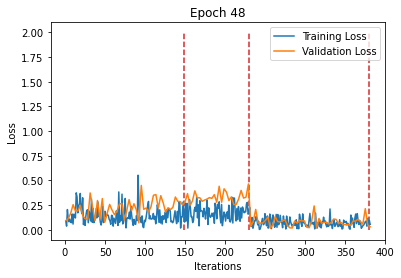

Train



Sequence:1, Seq Training Mean Loss: 0.12480205126519271, Seq Training Acc: 0.9421140939597316
******************************************************************



Sequence:2, Seq Training Mean Loss: 0.13914925455587146, Seq Training Acc: 0.9386574074074074
******************************************************************



Sequence:3, Seq Training Mean Loss: 0.0780988490395248, Seq Training Acc: 0.9658333333333333
******************************************************************
Epoch:49, Epoch Training Loss Mean: 0.10942479223012924, Epoch Training Acc: 0.9507401315789473
******************************************************************
Validation



******************************************************************
Sequence:1, Seq Valid Mean Loss: 0.20970901922912014, Seq Valid Acc: 0.9068877551020408



******************************************************************
Sequence:2, Seq Valid Mean Loss: 0.3447149136552104, Seq Valid Acc: 0.8483796296296297



******************************************************************
Sequence:3, Seq Valid Mean Loss: 0.08626677432097495, Seq Valid Acc: 0.965625
Epoch:49, Epoch Valid Mean Loss: 0.18965382874011993, Epoch Valid Acc: 0.9176587301587301
******************************************************************


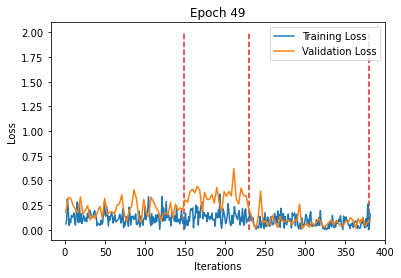

Train



Sequence:1, Seq Training Mean Loss: 0.12302419737031396, Seq Training Acc: 0.9469379194630873
******************************************************************



Sequence:2, Seq Training Mean Loss: 0.14849830460217264, Seq Training Acc: 0.9344135802469136
******************************************************************



Sequence:3, Seq Training Mean Loss: 0.07176524387963581, Seq Training Acc: 0.9691666666666666
******************************************************************
Epoch:50, Epoch Training Loss Mean: 0.10822039842605591, Epoch Training Acc: 0.9530427631578947
******************************************************************
Validation



******************************************************************
Sequence:1, Seq Valid Mean Loss: 0.20476046675930218, Seq Valid Acc: 0.9056122448979592



******************************************************************
Sequence:2, Seq Valid Mean Loss: 0.3504312336444855, Seq Valid Acc: 0.8622685185185185



******************************************************************
Sequence:3, Seq Valid Mean Loss: 0.08223583426326514, Seq Valid Acc: 0.96375
Epoch:50, Epoch Valid Mean Loss: 0.18735474348068237, Epoch Valid Acc: 0.9193948412698413
******************************************************************


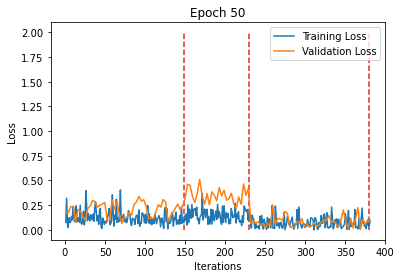


Save Model
Finished Training


In [28]:
if run_train:
    writer = SummaryWriter('runs/008_Run_Optunav2_1stripe')
    max_iter_per_seq = 150
    # 训练迭代总步数
    num_train_iter_per_epoch = 0
    num_train_iterations = [] # For plot parting line
    num_train_iterations_per_dl = [max_iter_per_seq if len(dl)>= max_iter_per_seq else len(dl) for dl in train_dls]
    for seq_dataloaders in dataloaders:
        if len(seq_dataloaders[train_dl_idx]) <= max_iter_per_seq:
            num_train_iter_per_epoch += len(seq_dataloaders[train_dl_idx])
        else:
            num_train_iter_per_epoch += max_iter_per_seq
        num_train_iterations.append(num_train_iter_per_epoch)
    print("Total Train Iterations: ",num_train_iter_per_epoch)
    print("Total Train Iterations List: ",num_train_iterations)
        
    # 训练迭代总步数为验证迭代总步数的3倍
    num_val_iterations = [int(number / 3) for number in num_train_iterations]
    num_val_iter_per_epoch = num_val_iterations[-1]
    
    # iterations in every seq
    num_val_iter_per_seq = []
    num_val_iter_per_seq.append(num_val_iterations[0])
    for i in range(len(num_val_iterations)-1):
        diff = num_val_iterations[i+1] - num_val_iterations[i] # The latter minus the former
        num_val_iter_per_seq.append(diff)
        
    print("Valid iterations per seq: ",num_val_iter_per_seq)
        
    optimizer = torch.optim.Adam(model.parameters(),lr=lr,eps=1e-08)

    scheduler = OneCycleLR(optimizer, num_train_iter_per_epoch, num_epochs, min_lr_factor=min_lr_factor)
    scheduler.step(epoch=0)
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.
    loss_min = 0.
    
    for epoch in tqdm(range(1,num_epochs+1)):

        print('Train')

        model.train()
        
        running_corrects = 0

        train_loss_array = np.zeros(num_train_iter_per_epoch, dtype=np.single)

        # mse_y = torch.zeros(batch_sizes[0]//2).to(device)
        
        i = 0
        seq_idx = 1
        for (refs, train_dl, max_num) in zip(refs_list, train_dls, num_train_iterations_per_dl):
            # obtain the refs in every seq
            
            curr_train_dl = train_dl

            curr_refs = refs.float().to(device)

            # Training
            dl_iter = iter(curr_train_dl)
            
            # This two only used to compute the loss and acc in every Sequence
            running_loss = 0
            corrects = 0
            for idx in tqdm(range(max_num)):
                if idx >= max_iter_per_seq:
                    break
                try:
                    img1, img2, targets = next(dl_iter)

                except (StopIteration, TypeError):
                    dl_iter = iter(curr_train_dl)
                    img1, img2, targets = next(dl_iter)
                
                scheduler.zero_grad()

                img1 = img1.float().to(device)
                img2 = img2.float().to(device)
                targets = targets.view(-1)
                targets = targets.float().to(device)

                # forward pass
                loss, preds = model.compute_loss(img1, img2, curr_refs, targets)
                
                loss.backward()
                
                running_loss += loss.item()
                corrects += torch.sum(preds == targets)
                running_corrects += torch.sum(preds == targets)

                train_loss_array[i] = loss.cpu().detach().numpy()
               
                
                # record loss and accuracy per iteration
                c = torch.sum(preds == targets)
                acc = int(c) / img1.size(0)
                writer.add_scalar('Train/Loss per Iteration',train_loss_array[i], ((epoch - 1) * num_train_iter_per_epoch)+ i)
                writer.add_scalar('Train/Acc per Iteration',acc, ((epoch - 1) * num_train_iter_per_epoch)+ i)
                
                # Record the lr
                curr_lr = get_lr(optimizer)
                writer.add_scalar('Train/Learning Rate',curr_lr , ((epoch - 1) * num_train_iter_per_epoch)+ i)
                
                i += 1
                scheduler.step()
            
            # record loss and accuracy in every train dataloader (namely every Sequence)
            #seq_train_mean_loss = running_loss / len(curr_train_dl)
            #seq_train_acc = int(corrects) / (len(curr_train_dl) * img1.size(0))
            seq_train_mean_loss = running_loss / max_num
            seq_train_acc = int(corrects) / (max_num * img1.size(0))
            
            print("Sequence:{}, Seq Training Mean Loss: {}, Seq Training Acc: {}".format(seq_idx, seq_train_mean_loss, seq_train_acc))
            print("******************************************************************")
            # Record the loss and acc in every Seq in Tensorboard
            writer.add_scalar('Train/Seq Training Mean Loss',seq_train_mean_loss, (epoch - 1) * len(train_dls) + seq_idx)
            writer.add_scalar('Train/Seq Training Accuracy', seq_train_acc, (epoch - 1) * len(train_dls) + seq_idx)
            writer.add_scalar('Train/Seq Error Rate',1 - seq_train_acc, (epoch - 1) * len(train_dls) + seq_idx)
            
            seq_idx += 1
            
        # after one epoch update scheduler   
        # Plot lr policy
        curr_lr = get_lr(optimizer)
        writer.add_scalar('Train/Learning Rate Policy',curr_lr , epoch)
        writer.flush()
            
        # record loss and accuracy in every epoch (namely 6 Sequences)
        epoch_train_mean_loss = train_loss_array.mean()  # std
        epoch_train_acc = int(running_corrects) / (num_train_iter_per_epoch * img1.size(0))

        print("Epoch:{}, Epoch Training Loss Mean: {}, Epoch Training Acc: {}".format(epoch, epoch_train_mean_loss, epoch_train_acc))
        print("******************************************************************")
        
        ### Validation
        print('Validation')
        model.eval()
        val_loss_array = np.zeros(num_val_iter_per_epoch, dtype=np.single)
        
        running_corrects = 0

        i = 0
        with torch.no_grad():
            seq_idx = 1
            for (refs, valid_dl, max_num) in zip(refs_list,valid_dls, num_val_iter_per_seq):
                
                curr_valid_dl = valid_dl
                curr_refs = refs.float().to(device)
                iter_max_num = max_num
            
                dl_iter = iter(curr_valid_dl)
                # This two uesd to compute loss and accurary in every Seq
                running_loss = 0
                corrects = 0
                for dl_idx in tqdm(range(iter_max_num)):
                    try:
                        img1, img2, targets = next(dl_iter)
                    except (StopIteration, TypeError):
                        dl_iter = iter(curr_valid_dl)
                        img1, img2, targets = next(dl_iter)

                    img1 = img1.float().to(device)
                    img2 = img2.float().to(device)
                    targets = targets.view(-1)
                    targets = targets.float().to(device)
                
                    loss, preds = model.compute_loss(img1, img2, curr_refs, targets)
                    
                    running_loss += loss.item()
                    corrects += torch.sum(preds == targets)
                    running_corrects += torch.sum(preds == targets)
                    
                    # record loss and accuracy in every iteration
                    c = torch.sum(preds == targets)
                    acc = int(c) / img1.size(0)
                    writer.add_scalar('Validation/Loss per Iteration',loss.item(), ((epoch - 1) * num_val_iter_per_epoch)+ i)
                    writer.add_scalar('Validation/Acc per Iteration',acc, ((epoch - 1) * num_val_iter_per_epoch)+ i)

                    val_loss_array[i] = loss.cpu().detach().numpy()
                    i += 1
            
                #seq_val_mean_loss = running_loss / len(curr_valid_dl)
                #seq_val_acc = int(corrects) / (len(curr_valid_dl) * img1.size(0))
                seq_val_mean_loss = running_loss / iter_max_num
                seq_val_acc = int(corrects) / (iter_max_num * img1.size(0))
                print("******************************************************************")
                print("Sequence:{}, Seq Valid Mean Loss: {}, Seq Valid Acc: {}".format(seq_idx,seq_val_mean_loss, seq_val_acc))
                
                writer.add_scalar('Validation/Seq Mean Loss',seq_val_mean_loss, (epoch - 1) * len(valid_dls) + seq_idx)
                writer.add_scalar('Validation/Seq Accuracy', seq_val_acc, (epoch - 1) * len(valid_dls) + seq_idx)
                writer.add_scalar('Validation/Seq Error Rate',1 - seq_val_acc, (epoch - 1) * len(valid_dls) + seq_idx)
                
                seq_idx += 1
                
            epoch_val_mean_loss = val_loss_array.mean()  # std
            epoch_val_acc = int(running_corrects) / (num_val_iter_per_epoch * img1.size(0))

            print("Epoch:{}, Epoch Valid Mean Loss: {}, Epoch Valid Acc: {}".format(epoch, epoch_val_mean_loss, epoch_val_acc))
            print("******************************************************************")
            
        # save best model weights
        if epoch_val_acc > best_acc:
            best_model_wts = copy.deepcopy(model.state_dict())
            loss_min = epoch_val_mean_loss
            
        # Tensorboard
        writer.add_scalars('Epoch/Loss', {"Training Loss": epoch_train_mean_loss,
                                          "Validation Loss": epoch_val_mean_loss}, epoch)
        writer.add_scalars('Epoch/Accuracy', {"Training Accuracy":epoch_train_acc,
                                              "Validation Accuracy": epoch_val_acc}, epoch)
        writer.add_scalars('Epoch/Error Rate', {"Training": 1 - epoch_train_acc,
                                                "Validation": 1 - epoch_val_acc}, epoch)
        writer.flush()
        
        plt.plot(np.linspace(1, train_loss_array.size+1, train_loss_array.size), train_loss_array,label='Training Loss')
        plt.plot(np.linspace(1, train_loss_array.size+1, val_loss_array.size), val_loss_array, label='Validation Loss')
        
        train_parting_line = num_train_iterations  # 1128 iterations in total in training
        val_parting_line = num_val_iterations  # 373 iterations in total in validation
        plt.vlines(train_parting_line, 0, 2, colors = "tab:red", linestyles = "dashed")
        
        plt.title('Epoch {}'.format(epoch))
        plt.xlabel('Iterations')
        plt.ylabel('Loss')
        plt.legend(loc='upper right')
        plt.show()
        
    print("Save Model")
    torch.save(model, net_path + '/m-' + timestampStr)
    torch.save({'epoch': epoch, 
                'state_dict': best_model_wts, 
                'best_loss': loss_min,
                'optimizer': optimizer.state_dict()},
                net_path + '/m-' + timestampStr + '-' + str("%.4f" % loss_min) + '.pth.tar')
    # add model to tensorboard
    #writer.add_graph(model,(img1, curr_refs, targets))
    writer.flush()

    print('Finished Training')
        
        

In [29]:
batch_size = 32
valid_dl_idx = 1
num_test_iter_per_epoch = 0
for seq_dataloaders in dataloaders:
    num_test_iter_per_epoch += len(seq_dataloaders[2])
    
model.eval()
y_vect = np.zeros(batch_size * num_test_iter_per_epoch)
y_tilde_vect = np.zeros(batch_size * num_test_iter_per_epoch)

i = 0
with torch.no_grad():
    seq_idx = 1
    
    running_corrects = 0

    test_loss_array = np.zeros(num_test_iter_per_epoch, dtype=np.single)
    
    for (refs, test_dl) in zip(refs_list,valid_dls):
        
        curr_test_dl = test_dl
        
        curr_refs = refs.float().to(device) 

        dl_iter = iter(curr_test_dl)
        
        # This two uesd to compute loss and accurary in every Seq
        running_loss = 0
        corrects = 0

        for dl_idx in tqdm(range(len(curr_test_dl))):
            try:
                img1, img2, targets = next(dl_iter)
            except (StopIteration, TypeError):
                dl_iter = iter(curr_valid_dl)
                img1, img2, targets = next(dl_iter)

            scheduler.zero_grad()
            img1 = img1.float().to(device)
            img2 = img2.float().to(device)
            targets = targets.view(-1)
            targets = targets.float().to(device)
              
            loss, preds = model.compute_loss(img1, img2, curr_refs, targets)
                    
            running_loss += loss.item()
            corrects += torch.sum(preds == targets)
            
            test_loss_array[i] = loss.cpu().detach().numpy()

            y_vect[i*batch_size:(i+1)*batch_size] = targets.detach().cpu().numpy()
            y_tilde_vect[i*batch_size:(i+1)*batch_size] = preds.detach().cpu().numpy()
            
            # record loss and accuracy per iteration
            c = torch.sum(preds == targets)
            acc = int(c) / img1.size(0)
            
            writer.add_scalar('Test/Loss per Iteration',test_loss_array[i], i)
            writer.add_scalar('Test/Acc per Iteration',acc, i)
            writer.add_scalar('Test/Error Rate', 1 - acc, i)

            i += 1
        # record seq test loss and acc
        seq_test_mean_loss = running_loss / len(curr_test_dl)
        seq_test_acc = int(corrects) / (len(curr_test_dl) * img1.size(0))
        
        print("******************************************************************")
        print("Test: Sequence:{}, Seq Mean Loss: {}, Seq Acc: {}".format(seq_idx,seq_test_mean_loss, seq_test_acc))
            
        writer.add_scalar('Test/Seq Loss', seq_test_mean_loss, seq_idx)
        writer.add_scalar('Test/Seq Accuracy', seq_test_acc, seq_idx)
        writer.add_scalar('Test/Seq Error Rate', 1 - seq_test_acc, seq_idx)
        
        seq_idx += 1

writer.close()
                                      
print("Test finished")


******************************************************************
Test: Sequence:1, Seq Mean Loss: 0.21773476472922734, Seq Acc: 0.8973214285714286



******************************************************************
Test: Sequence:2, Seq Mean Loss: 0.3381476551294327, Seq Acc: 0.8472222222222222



******************************************************************
Test: Sequence:3, Seq Mean Loss: 0.08082620681808242, Seq Acc: 0.9607900943396226
Test finished


In [30]:
def init_test_dataset(path,seq_idx_list,mean_val,std_val):

    ds_h5 = []
    refs_list = []

    img_transforms = [RandomRotateGrayscale(rot_range=[-0.1, 0.1], fill=150),
                      RandomFlip(lr_prob=0.5, ud_prob=0.5),
                      transforms.ToTensor(),
                      transforms.Normalize((mean_val,),(std_val,))]
    
    composed_img_transforms = transforms.Compose(img_transforms)
    
    # to obtain the Seq data
    for seq_idx in seq_idx_list:
        h5_fpath = path.format(seq_idx)
        h5_f = DatasetH5ForTest(h5_fpath, normalize_im=False, transform = composed_img_transforms)
        
        # obtain the references, the first 32 images in every Seq.
        refs = h5_f.getRef()
        refs_list.append(refs)
        
        ds_h5.append(h5_f)

    return refs_list, ds_h5

In [39]:
data_path_type2 = "../MA/NewData/21503_1000200411_653340003"
fnames_type2 = "trueroi_filtered_phase2_1_{}.h5" # 2,3,4
combined_path_type2 = os.path.join(data_path_type2, fnames_type2)
seq_idx_list_type2 = [1,2,3,4]

In [40]:
mean_val = 0
std_val = 255
refs_list, ds_h5_test = init_test_dataset(combined_path_type2, seq_idx_list_type2, mean_val, std_val)

In [41]:
ds_h5_test

In [42]:
batch_size = 1
test_dataloaders = []
for ds in ds_h5_test: 
    test_dataloader = DataLoader(dataset = ds, batch_size=batch_size, shuffle = False)
    test_dataloaders.append(test_dataloader)

In [43]:
import pandas as pd

In [44]:
all_seq_y_tilde_vect = np.zeros(0)
time_ids = []
seq_idx = 0
for refs,dl in zip(refs_list, test_dataloaders):

    curr_refs = refs.float().to(device)
    num_data = len(dl)
    print(num_data)
    
    loss_vect = np.zeros(num_data)
    var_res_vect= np.zeros(num_data)

    y_vect = np.zeros(num_data)
    y_tilde_vect = np.zeros(num_data)
    
    dl_iter = iter(dl)

    for i in tqdm(range(num_data)):
        try:
            img,label = next(dl_iter)

        except (StopIteration, TypeError):
            dl_iter = iter(curr_train_dl)
            img,label = next(dl_iter)
            
        y_vect[i] = label
        
        img = img.float().to(device)
                
        #targets = targets.float().to(device)
        
        #v1, refs_v = model.forward_test(img, curr_refs)
        #metric = degradation_metrics(v1,refs_v)
        
        metric = model.forward(img, curr_refs)
        
        y_tilde = metric.detach().cpu().numpy()

        var_res_vect[i] = np.var(y_tilde)

        y_tilde_vect[i] = y_tilde.mean()

        loss_vect[i] = np.abs(label - y_tilde_vect[i])
        
    
    time_ids.append(y_tilde_vect.size)
    mov_aver = pd.Series(y_tilde_vect).rolling(32, min_periods=1).mean()
    rel_outlier_idx = np.abs(y_tilde_vect - mov_aver) > 3
    np.save('optuna_v2_1stripe_720x24_outlier_{}.npy'.format(seq_idx), rel_outlier_idx)
    seq_idx += 1
        
    all_seq_y_tilde_vect = np.concatenate((all_seq_y_tilde_vect, y_tilde_vect))

15279



7995



4322



17013


<IPython.core.display.Javascript object>


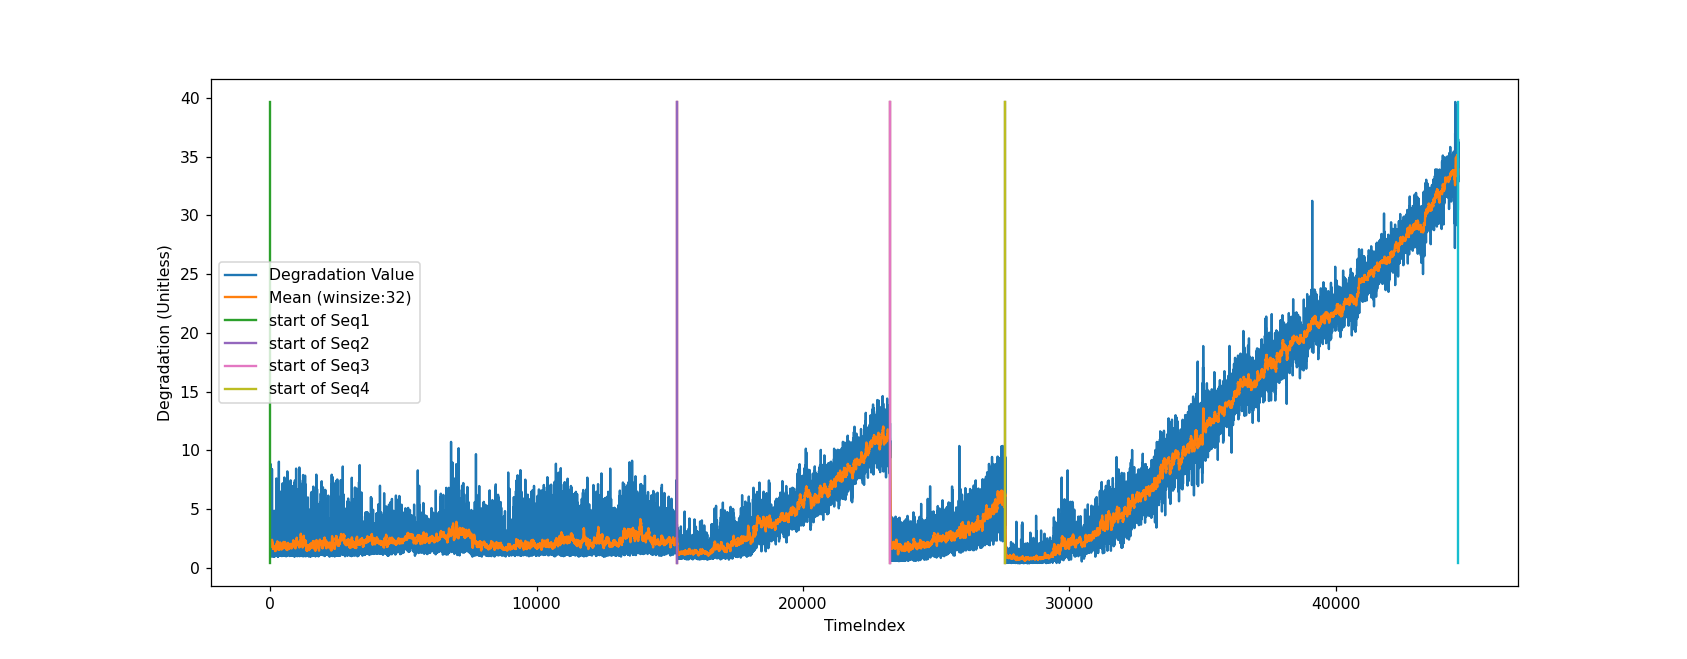

In [45]:
%matplotlib notebook
plt.plot(all_seq_y_tilde_vect, label='Degradation Value')
plt.plot(pd.Series(all_seq_y_tilde_vect).rolling(32).mean(), label='Mean (winsize:32)')

min_y = all_seq_y_tilde_vect.min()
max_y = all_seq_y_tilde_vect.max()


# Type 2 Data
seq_period_iloc = [
    [    0,  15279],
    [ 15279, 23274],
    [ 23274, 27596],
    [ 27596, 44609],
]

seq_index = 1
for stime_iloc, etime_iloc in seq_period_iloc:
    plt.plot([stime_iloc, stime_iloc], [min_y, max_y], label = "start of Seq{}".format(seq_index))
    plt.plot([etime_iloc, etime_iloc], [min_y, max_y])
    seq_index += 1


plt.ylabel("Degradation (Unitless)")
plt.xlabel("TimeIndex")

plt.legend()
plt.show()